In [3]:
# Import necessary libraries
import time
from math import sqrt
import os

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from IPython.display import display

from xgboost import XGBRegressor

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFECV
from sklearn.linear_model import BayesianRidge, ElasticNet, LinearRegression, Ridge, RidgeCV, SGDRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import Binarizer, MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

sns.set(font='serif', style='ticks')
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.sans-serif']=['Arial Unicode MS']

plt.rcParams['axes.unicode_minus']=False
pd.set_option('display.max_columns',None)

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.optimizers import Adam,Adamax,Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape, Dropout, RepeatVector

In [3]:
# Import necessary libraries
data1 = pd.read_csv('./Vm_vce.csv')
data2 = pd.read_csv('./Vm.csv')

X = data1[['m','c','v']]
Y1 = data2[['n', 'k']]
Y2 = data1[['Eg', 'd']]

In [4]:
# Standardize the data.
transfer1 = StandardScaler()
X = transfer1.fit_transform(X)

transfer2 = StandardScaler()
Y1 = transfer2.fit_transform(Y1)

transfer3 = StandardScaler()
Y2 = transfer3.fit_transform(Y2)
Y2.shape

(606, 2)

In [5]:
# Data is taken every 701 wavelengths
samples_per_slice = 701
n_samples = Y1.shape[0] // samples_per_slice
feature_slices_Y1 = Y1[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 2))
Y1 = np.stack(feature_slices_Y1, axis=0)
print(Y1.shape)  # (110, 701, 2)

(606, 701, 2)


In [6]:
# Splice Y2 to the very back of each 701 of Y1
Y2 = np.expand_dims(Y2, axis=1)  # 在Y2数组的第二维增加一个维度
Y = np.concatenate((Y1, Y2), axis=1)  # 沿着第二维度拼接Y1和Y2数组

print(Y.shape)  # 输出(606, 702, 2)

(606, 702, 2)


In [7]:
# Split the data into training and testing sets.
x_train, x_test, y_train, y_test =train_test_split(X, Y, test_size=0.2, random_state=24,shuffle=True)

In [ ]:
# Parameter optimization
def create_model(trial):
    # Network structure parameter
    gru_units=trial.suggest_categorical("gru_units", [8, 16, 32, 128,256,512])
    n_layers = trial.suggest_int("n_layers", 1, 6)
    filters = [trial.suggest_categorical(f"filters_{i}", [2, 4, 8, 16, 32, 64, 128, 256,512]) for i in range(n_layers)]
    kernel_size = [trial.suggest_categorical(f"kernel_size_{i}", [2, 3, 4, 5, 6, 7, 8, 9, 10])for i in range(n_layers)]
    activation = trial.suggest_categorical("activation", ['relu', 'tanh', 'elu', 'leaky_relu'])  # 添加Leaky ReLU和Parametric ReLU激活函数选项

    # Regularization parameter
    l2_strength = trial.suggest_float('l2_strength', 1e-100,1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)

    # Optimizer and learning rate 
    optimizer_options = ['Adam', 'Nadam', 'Adamax']  
    optimizer_choice = trial.suggest_categorical("optimizer", optimizer_options)
    learning_rate = trial.suggest_float("learning_rate", 1e-10, 1e-1, log=True)

    
    if optimizer_choice == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'Nadam':
        optimizer = Nadam(learning_rate=learning_rate)
    elif optimizer_choice == 'Adamax':
        optimizer = Adamax(learning_rate=learning_rate)

    kernel_regularizer = l2(l2_strength)
    model = Sequential()
    model.add(Dense(gru_units, activation=activation, input_shape=(3,)))
    model.add(RepeatVector(701))  # 将输入重复seq_length次来匹配输出的时间步长
    # Add the Conv1D layer
    for i in range(n_layers):
        if i == 0:
            model.add(Conv1D(filters=filters[i], kernel_size=kernel_size[i], activation=activation, kernel_regularizer=kernel_regularizer))
        else:
            model.add(Conv1D(filters=filters[i], kernel_size=kernel_size[i], activation=activation, kernel_regularizer=kernel_regularizer))
        model.add(MaxPooling1D(pool_size=2))
        
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(701 * 2))
    model.add(Reshape((701, 2)))

    # Compilation model
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

def objective(trial):
    # Create models
    model = create_model(trial)

    # Training parameter
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128, 256, 512])
    
    # Data partitioning
    validation_split = trial.suggest_float("validation_split", 0.1, 0.7)
                                           
    # EarlyStopping parameter
    patience = trial.suggest_int("patience", 5, 100)
    callbacks = [EarlyStopping(monitor='val_loss', patience=patience, min_delta=0.00001)]

    # Training model
    history = model.fit(x_train, y_train, callbacks=callbacks, epochs=500, batch_size=batch_size, validation_split=validation_split)

    # Select the best epoch
    val_loss = np.min(history.history['val_loss'])

    # Clear the current TensorFlow diagram
    tf.keras.backend.clear_session()

    return val_loss

# Create a study object
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)  # 根据需要设置尝试次数

# Print optimum parameter
print(study.best_params)

In [ ]:
print("Best params:", study.best_params)
print("Best value:", study.best_value)

# Prints all parameters and values
print("All params and values:")
for trial in study.trials:
    print("Trial #{}: params={}, value={}".format(trial.number, trial.params, trial.value))

In [4]:
# Build the model according to the best parameters
l2_reg = l2(3.275606796405715e-53)

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(3,)))
model.add(RepeatVector(702))  # Repeat the input seq length multiple times to match the time step of the output
model.add(Conv1D(filters=128, kernel_size=2, activation='leaky_relu', kernel_regularizer=l2_reg))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=256, kernel_size=2, activation='leaky_relu', kernel_regularizer=l2_reg))
model.add(MaxPooling1D(pool_size=2))

model.add(Dropout(0.3239003696928051))
model.add(Flatten())
model.add(Dense(702 * 2, activation='relu'))
model.add(Reshape((702, 2)))

# Output model structure
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               512       
                                                                 
 repeat_vector (RepeatVecto  (None, 702, 128)          0         
 r)                                                              
                                                                 
 conv1d (Conv1D)             (None, 701, 128)          32896     
                                                                 
 max_pooling1d (MaxPooling1  (None, 350, 128)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 349, 256)          65792     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 174, 256)         

In [28]:
from tensorflow.keras.regularizers import l2
callbacks = [EarlyStopping(monitor='val_loss', patience=30, verbose=1, min_delta=0.00001)]

In [ ]:
# Compilation model
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0003979144438333008))

# Training model
history = model.fit(x_train, y_train, callbacks=callbacks,epochs=1000, batch_size=32, validation_split=0.10874977029910923)

In [ ]:
# Plot loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Predictive test set
y_pred = model.predict(x_test)

In [10]:
# Fetch the second dimension data
z2 = y_pred[:, -1, :]  # Fetch the data for the last dimension
z1 = y_pred[:, :-1, :]  # Fetch the data except for the last dimension

print(z1.shape)  
print(z2.shape) 

(122, 701, 2)
(122, 2)


In [11]:
# Fetch the second dimension data
z4 = y_test[:, -1, :]   # Fetch the data for the last dimension
z3 = y_test[:, :-1, :]  # Fetch the data except for the last dimension
print(z3.shape)  
print(z4.shape) 

(122, 701, 2)
(122, 2)


In [12]:
z1 = z1.reshape(-1, 2)
print(z1.shape)

z3 = z3.reshape(-1, 2)
print(z3.shape)

(85522, 2)
(85522, 2)


In [13]:
# Restore the normalized output to the original value
z1 = transfer2.inverse_transform(z1)
z3 = transfer2.inverse_transform(z3)

In [14]:
# Restore the normalized output to the original value
z2 = transfer3.inverse_transform(z2)
z4 = transfer3.inverse_transform(z4)

In [15]:
# Extract the first and second columns
n_pred = z1[:, 0]
n_test = z3[:, 0]
k_pred = z1[:, 1]
k_test = z3[:, 1]

Eg_pred = z2[:, 0]
Eg_test = z4[:, 0]
d_pred = z2[:, 1]
d_test = z4[:, 1]

print(n_pred.shape)  
print(n_test.shape)  
print(k_pred.shape)  
print(k_test.shape) 
print(Eg_pred.shape)  
print(Eg_test.shape)  
print(d_pred.shape)  
print(d_test.shape)  

(85522,)
(85522,)
(85522,)
(85522,)
(122,)
(122,)
(122,)
(122,)


In [17]:
# Calculate the loss of n
mse = mean_squared_error(n_test, n_pred)
print("n_test MSE: ", mse)
rmse = np.sqrt(mse)
print("n_test RMSE: ", rmse)
mae = mean_absolute_error(n_test, n_pred)
print("n_test MAE: ", mae)
r2 = r2_score(n_test, n_pred)
print("n_test R2 score: ", r2)

n_test MSE:  0.00899295922183509
n_test RMSE:  0.0948312143855339
n_test MAE:  0.06675099278028025
n_test R2 score:  0.8679094910301172


In [18]:
# Calculate the loss of k
mse = mean_squared_error(k_test, k_pred)
print("k_test MSE: ", mse)
rmse = np.sqrt(mse)
print("k_test RMSE: ", rmse)
mae = mean_absolute_error(k_test, k_pred)
print("k_test MAE: ", mae)
r2 = r2_score(k_test, k_pred)
print("k_test R2 score: ", r2)

k_test MSE:  0.0016884242071467095
k_test RMSE:  0.041090439364245175
k_test MAE:  0.01737932162895277
k_test R2 score:  0.9893439960791671


In [19]:
# Calculate the loss of Eg
mse = mean_squared_error(Eg_test, Eg_pred)
print("Eg_test MSE: ", mse)
rmse = np.sqrt(mse)
print("Eg_test RMSE: ", rmse)
mae = mean_absolute_error(Eg_test, Eg_pred)
print("Eg_test MAE: ", mae)
r2 = r2_score(Eg_test, Eg_pred)
print("Eg_test R2 score: ", r2)

Eg_test MSE:  0.018230968518098415
Eg_test RMSE:  0.13502210381303653
Eg_test MAE:  0.09477329536767277
Eg_test R2 score:  0.8230346661453214


In [20]:
# Calculate the loss of d
mse = mean_squared_error(d_test, d_pred)
print("d_test MSE: ", mse)
rmse = np.sqrt(mse)
print("d_test RMSE: ", rmse)
mae = mean_absolute_error(d_test, d_pred)
print("d_test MAE: ", mae)
r2 = r2_score(d_test, d_pred)
print("d_test R2 score: ", r2)

d_test MSE:  2.535411977987072
d_test RMSE:  1.5922977039445456
d_test MAE:  1.1946056974129595
d_test R2 score:  0.8434085133297407


In [21]:
# Data is taken every 701 wavelengths
samples_per_slice = 701
n_samples = n_pred.shape[0] // samples_per_slice
feature_slices_pred = n_pred[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 1))
n_pred = np.stack(feature_slices_pred, axis=0)
print(n_pred.shape) 

samples_per_slice = 701
n_samples = n_test.shape[0] // samples_per_slice
feature_slices_test = n_test[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 1))
n_test = np.stack(feature_slices_test, axis=0)
print(n_test.shape)

samples_per_slice = 701
n_samples = k_pred.shape[0] // samples_per_slice
feature_slices_pred = k_pred[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 1))
k_pred = np.stack(feature_slices_pred, axis=0)
print(k_pred.shape) 

samples_per_slice = 701
n_samples = k_test.shape[0] // samples_per_slice
feature_slices_test = k_test[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 1))
k_test = np.stack(feature_slices_test, axis=0)
print(k_test.shape)

(122, 701, 1)
(122, 701, 1)
(122, 701, 1)
(122, 701, 1)


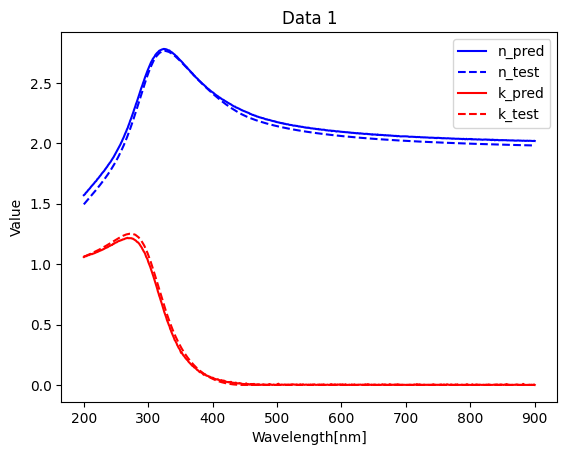

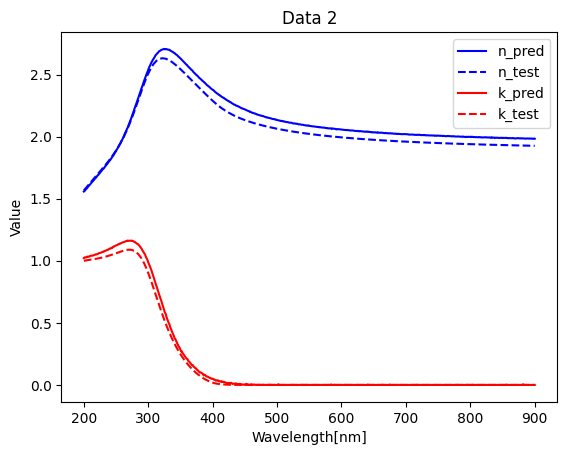

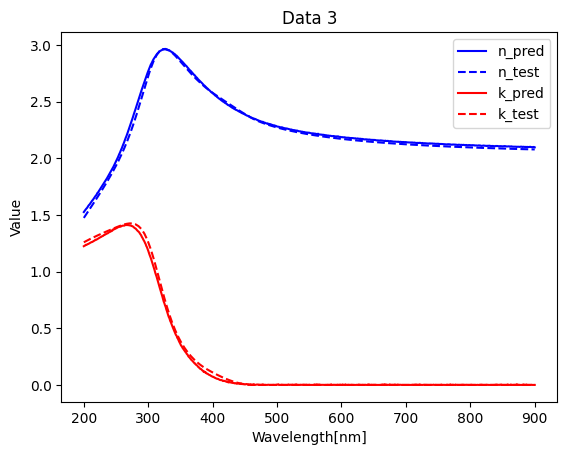

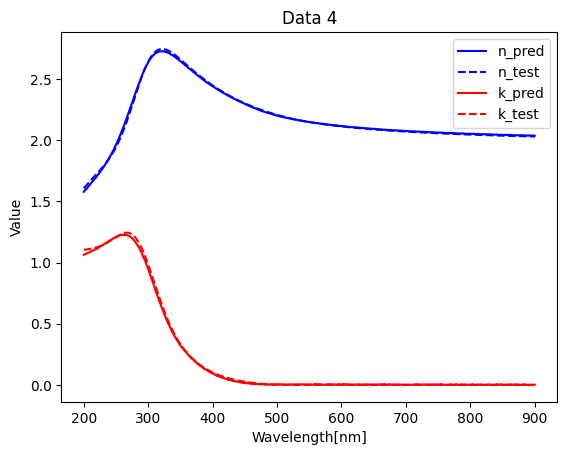

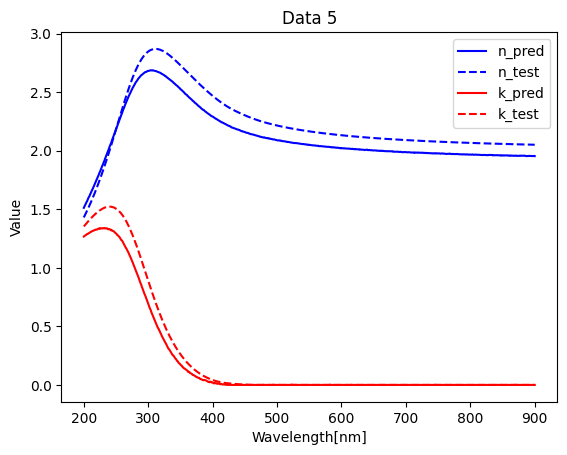

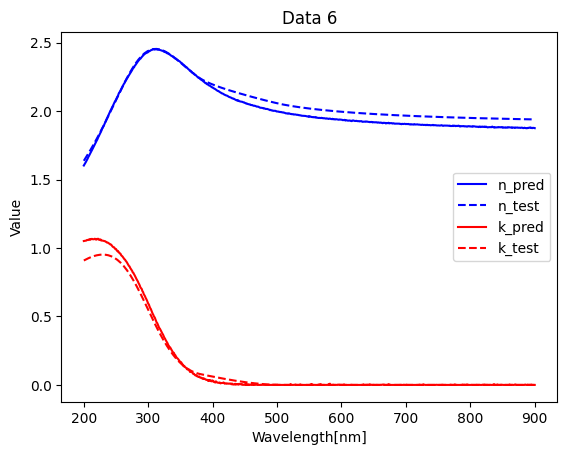

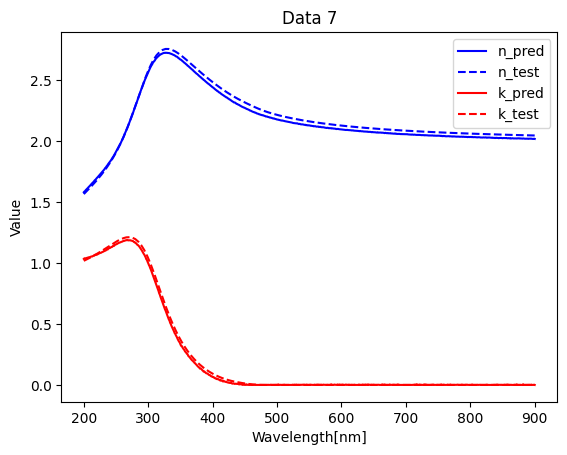

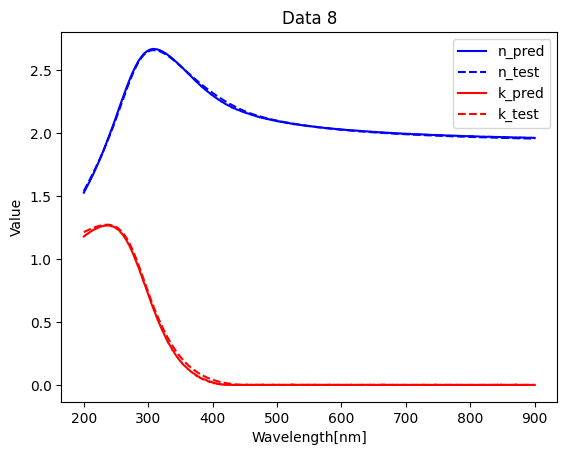

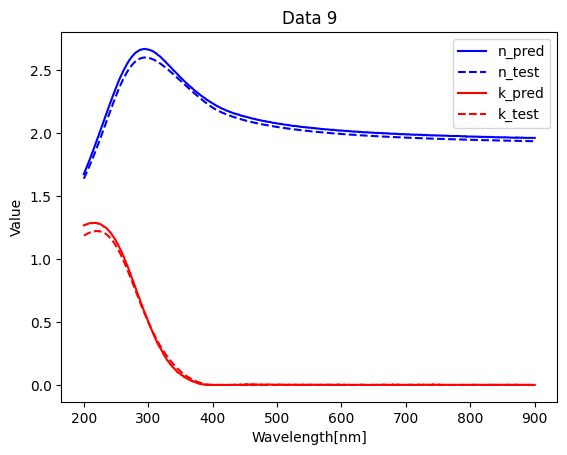

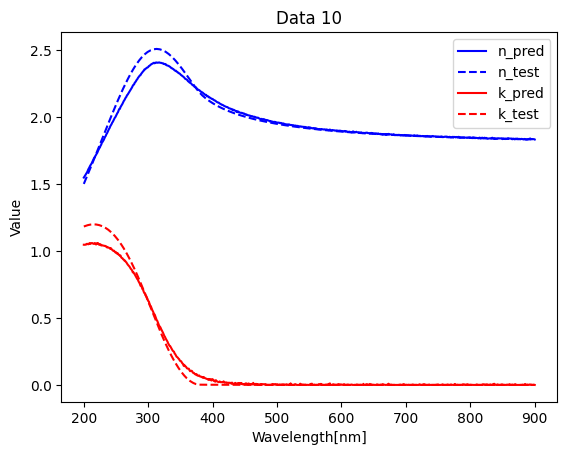

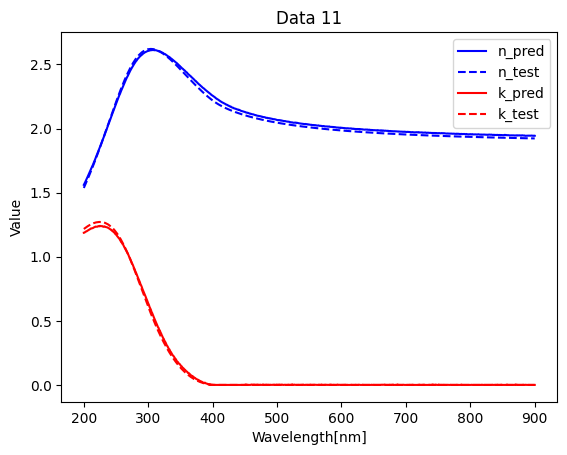

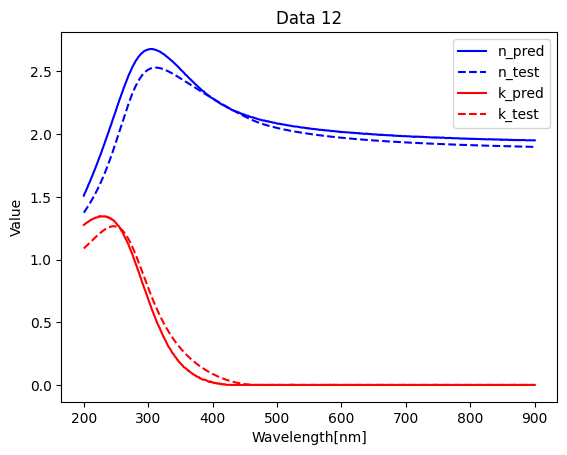

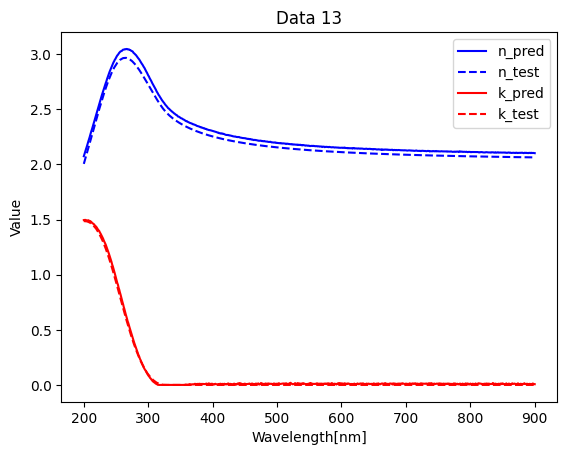

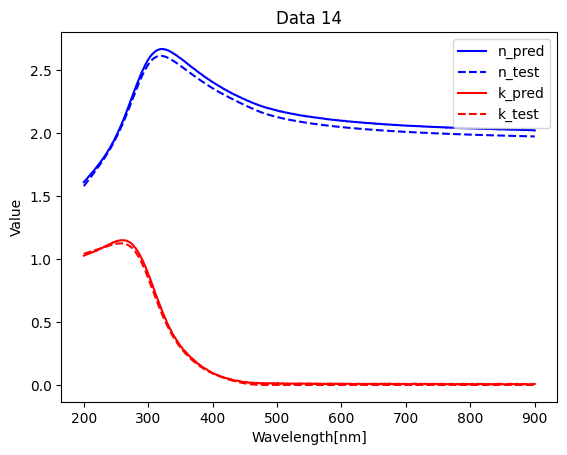

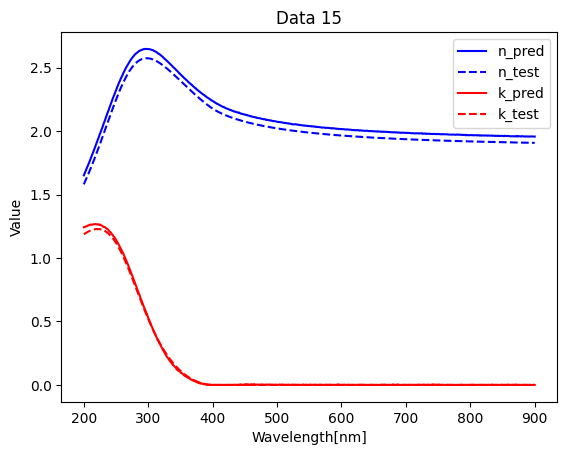

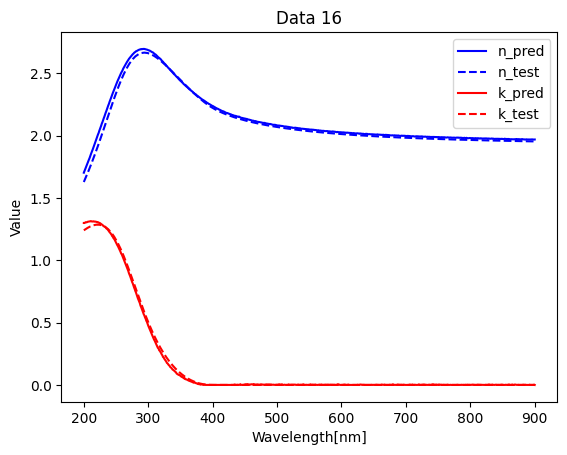

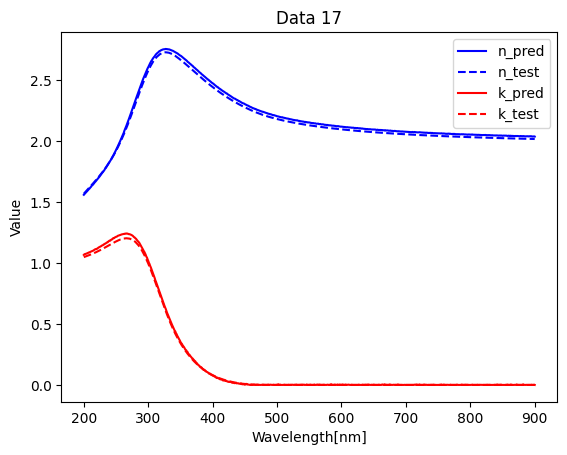

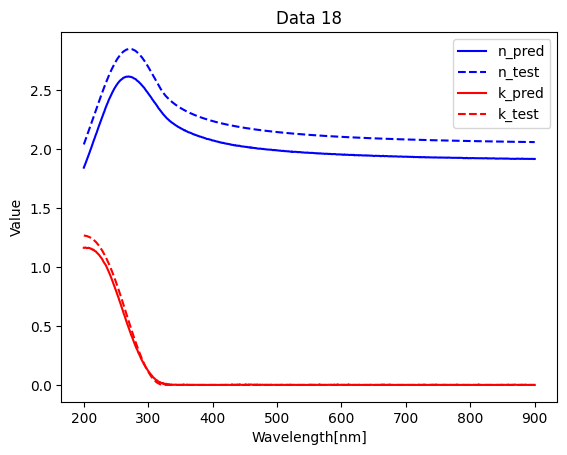

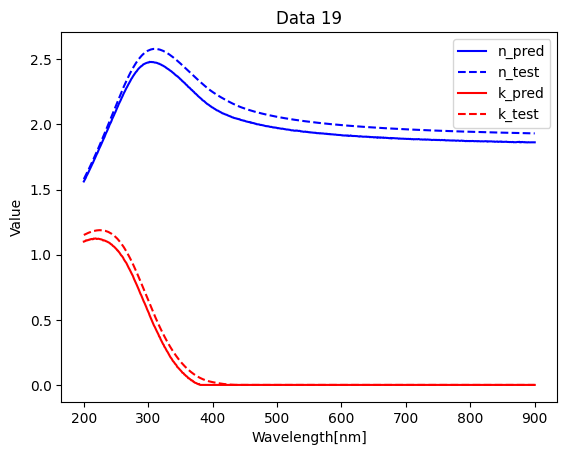

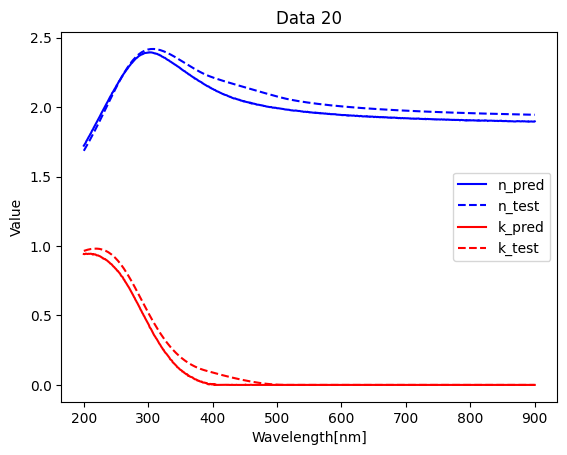

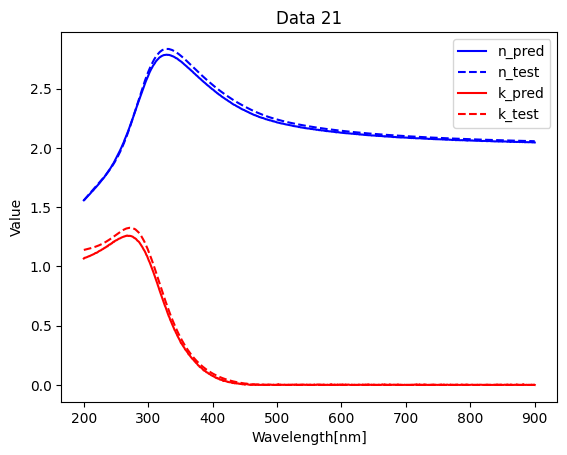

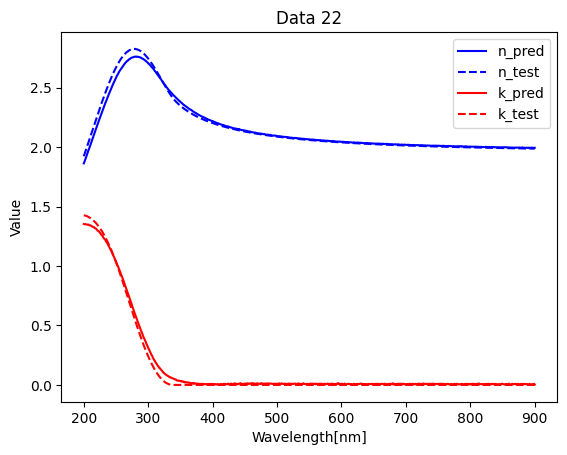

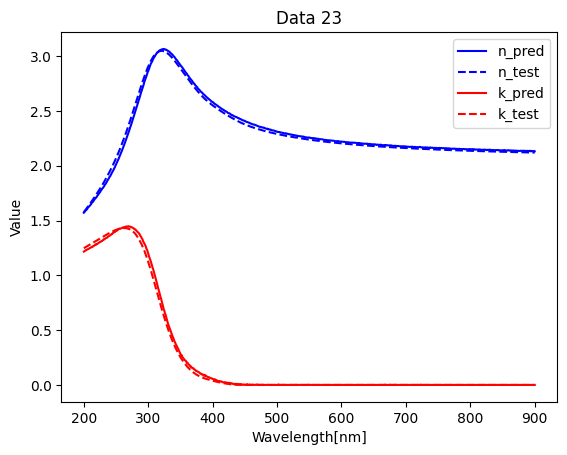

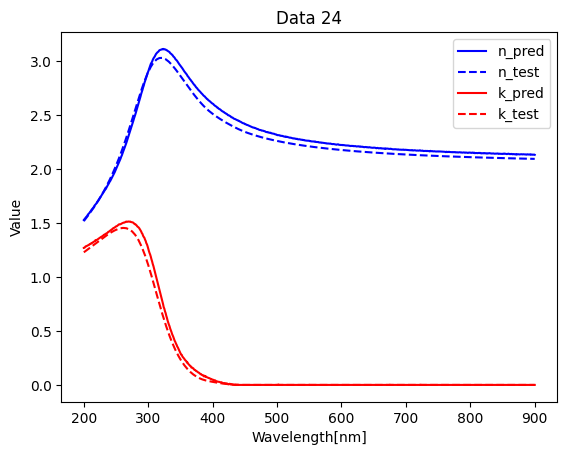

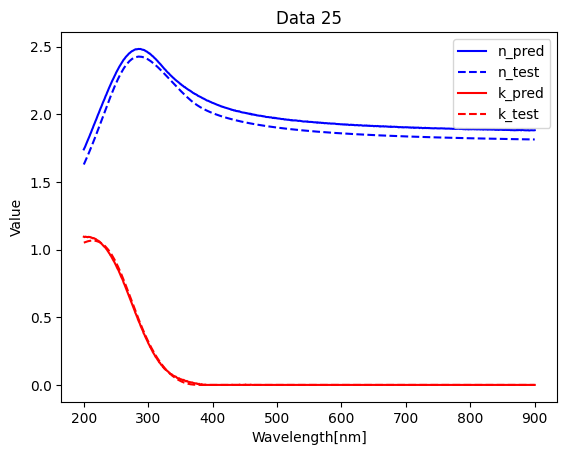

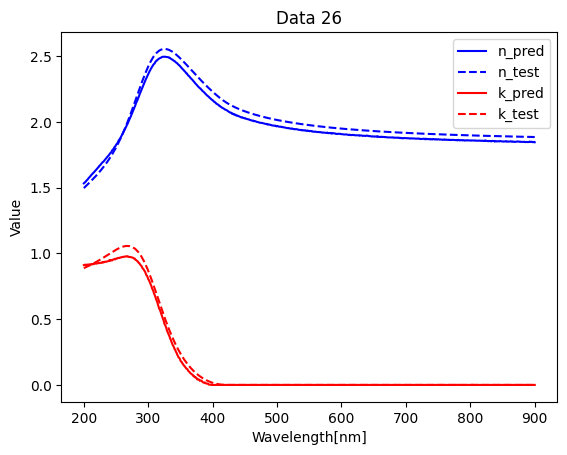

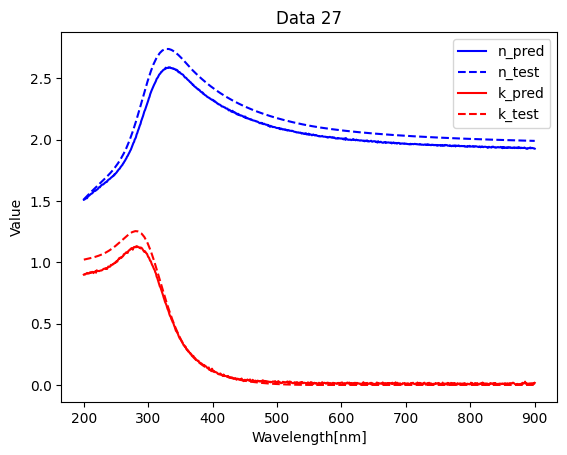

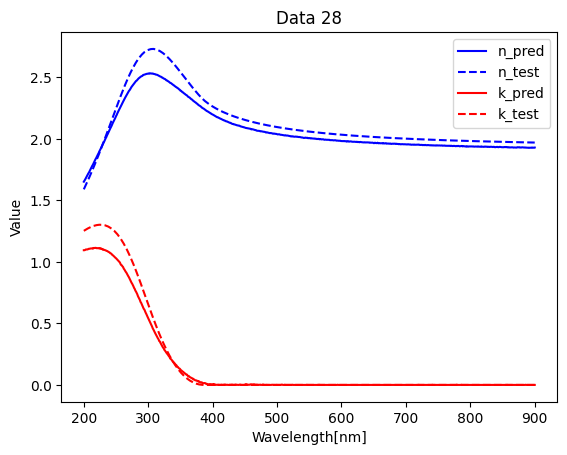

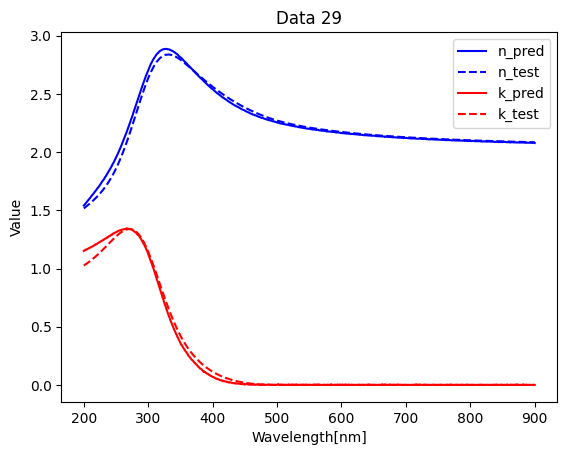

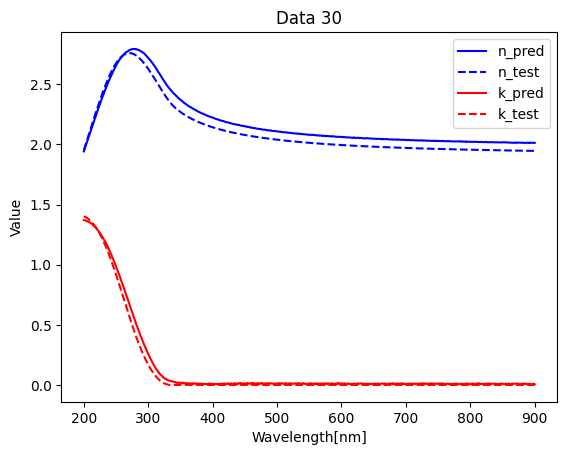

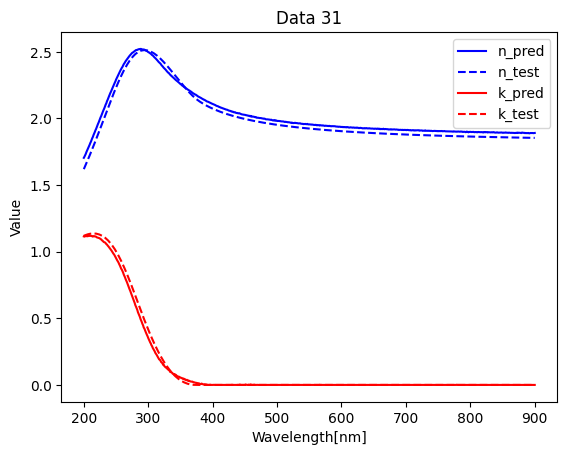

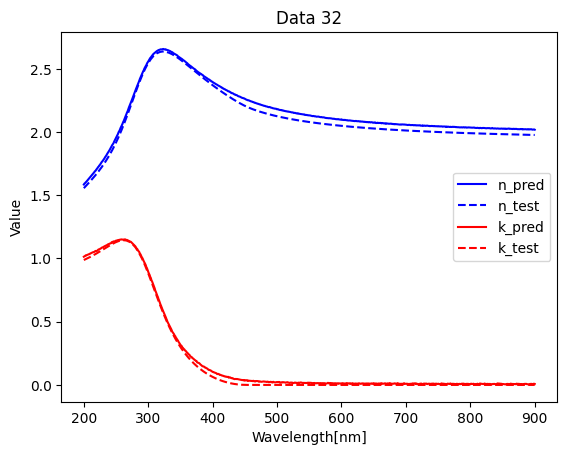

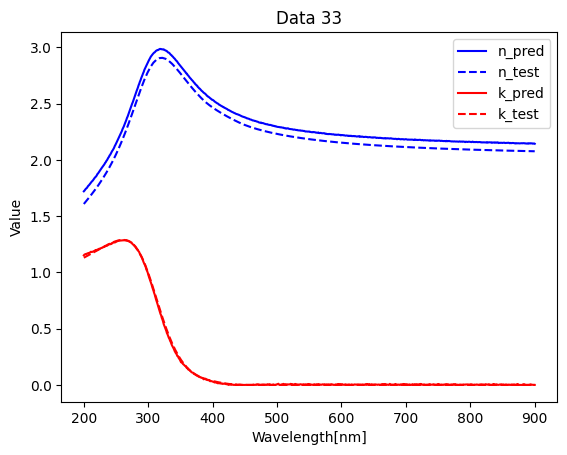

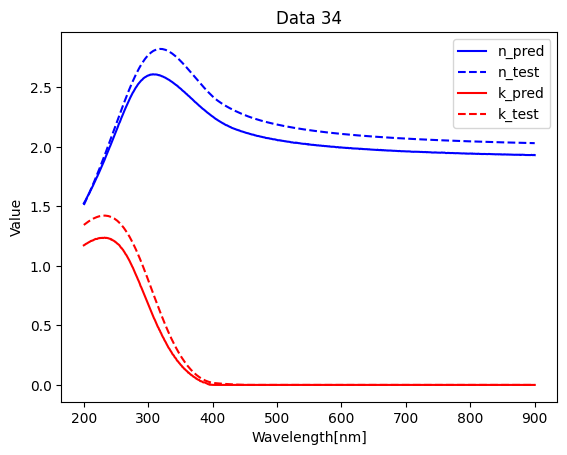

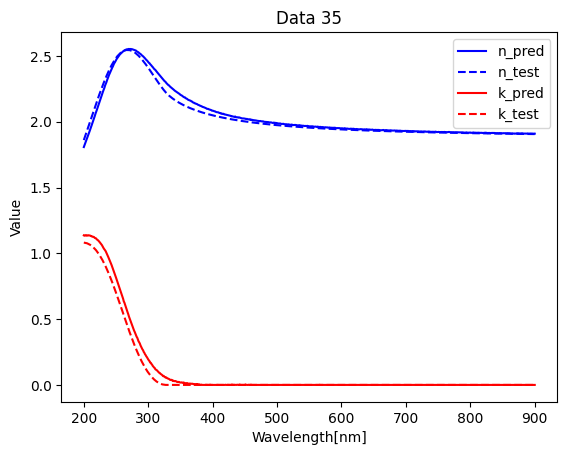

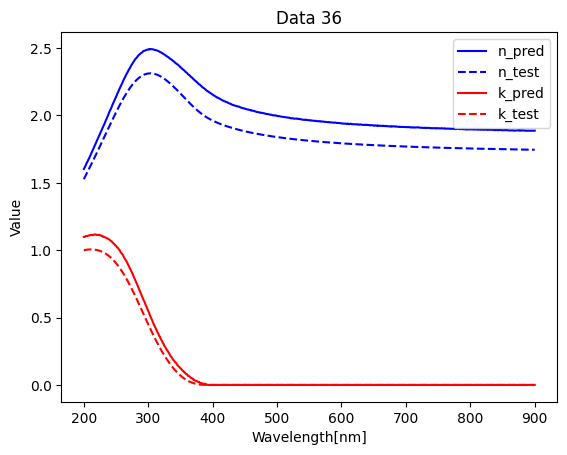

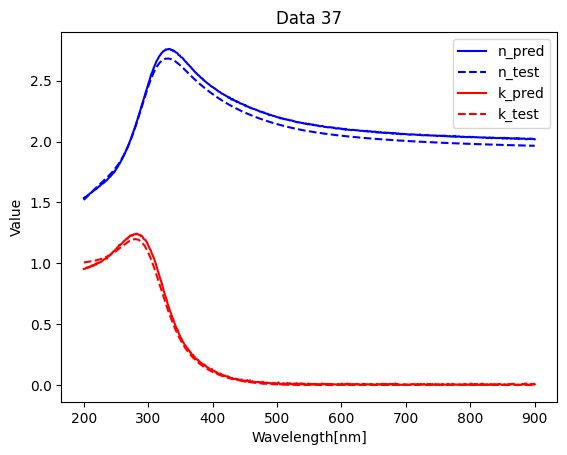

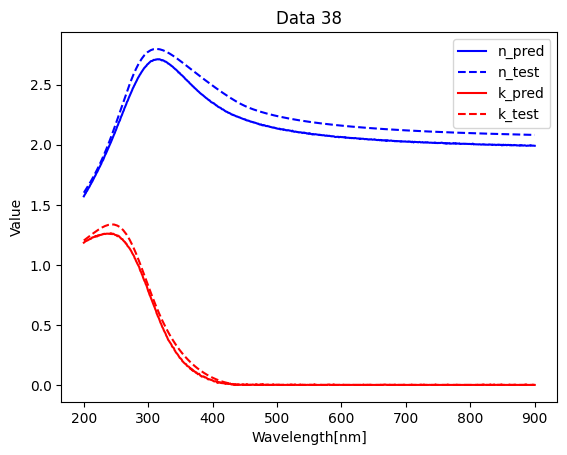

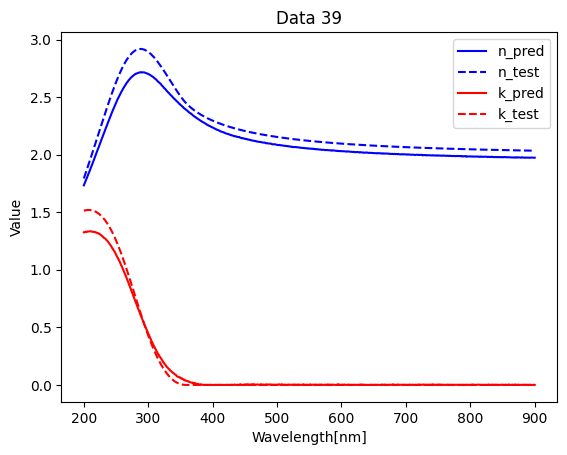

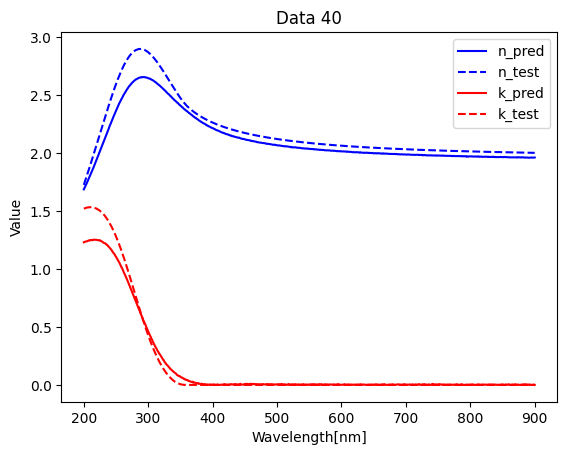

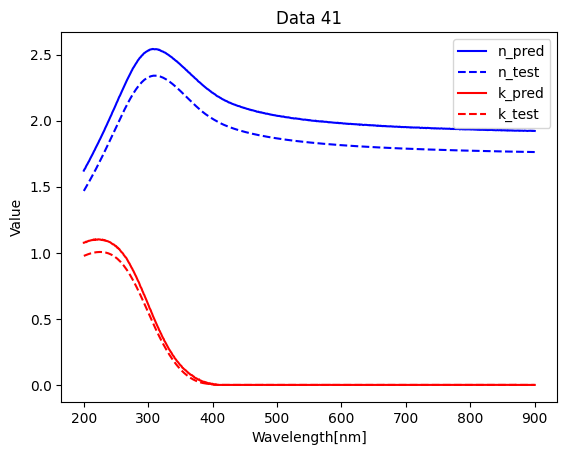

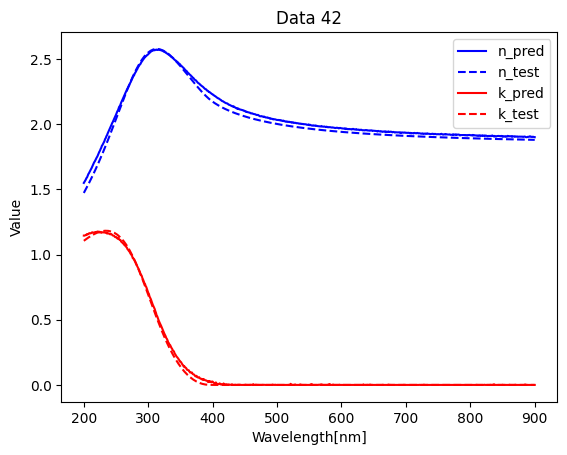

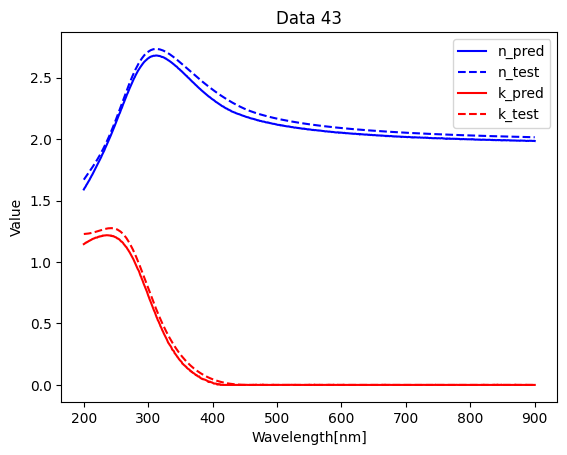

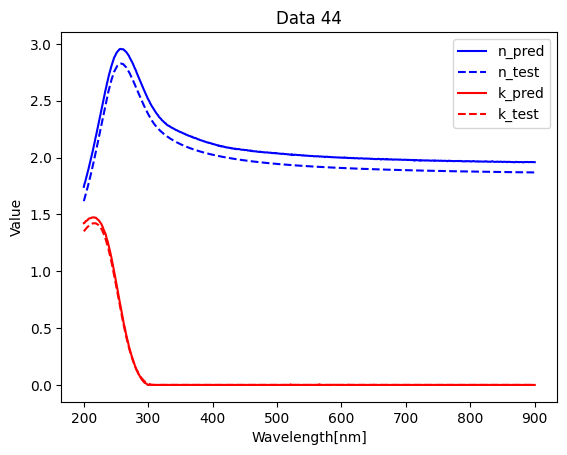

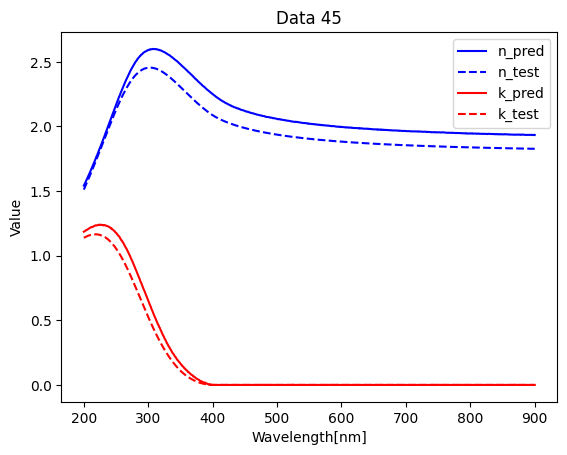

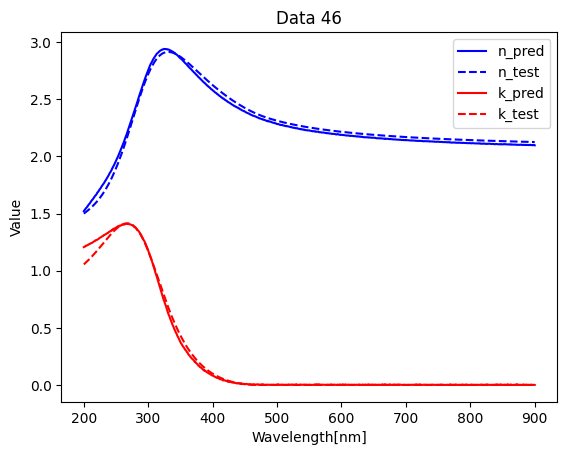

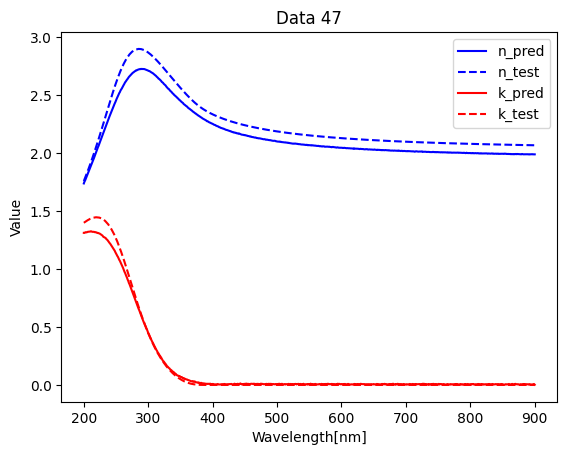

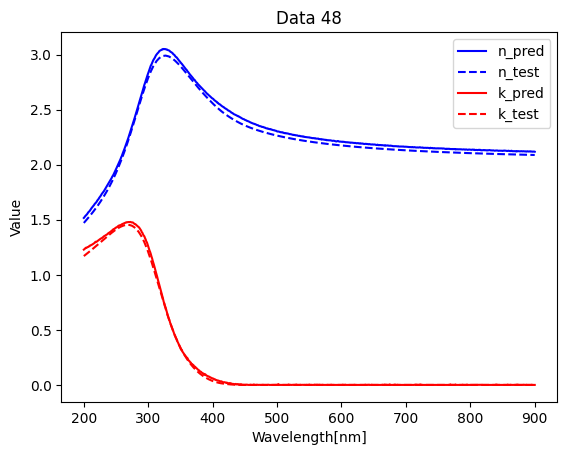

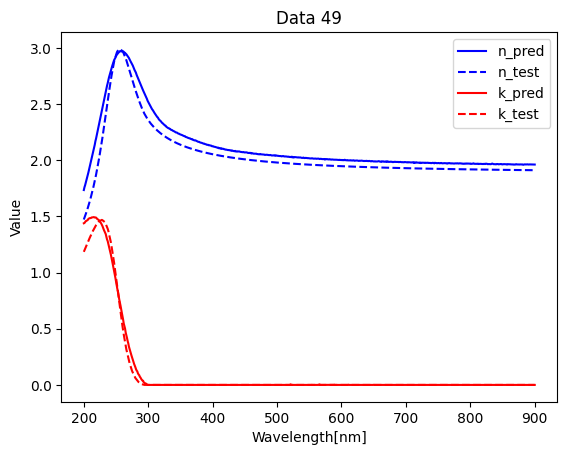

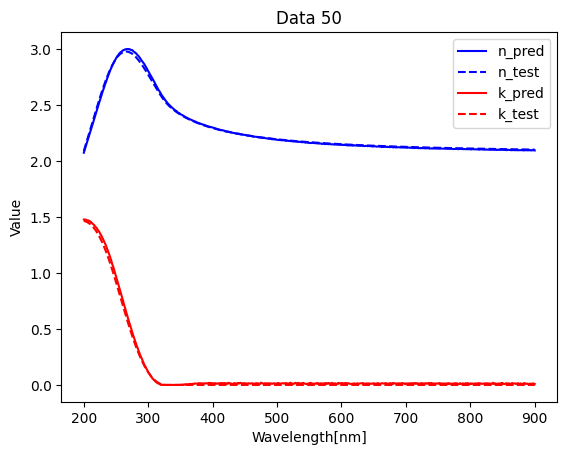

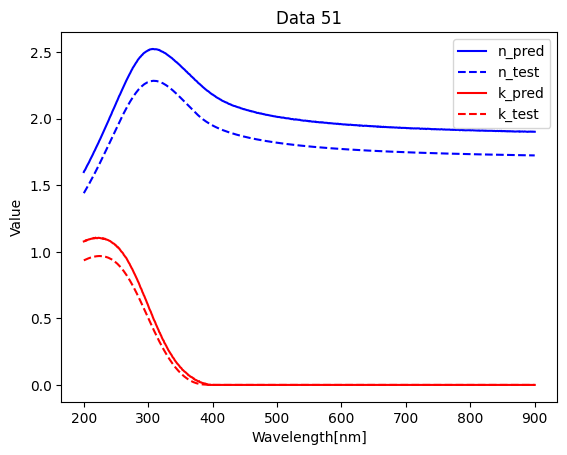

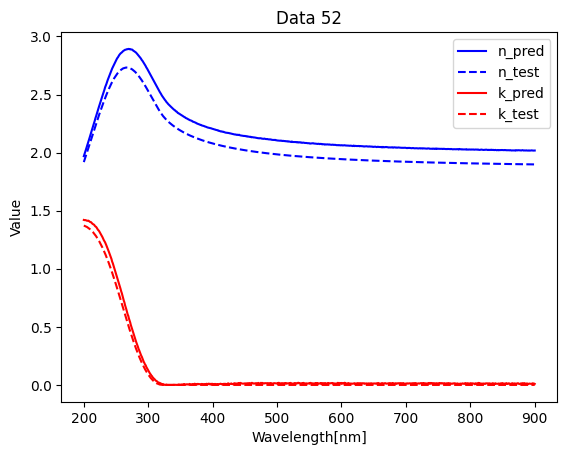

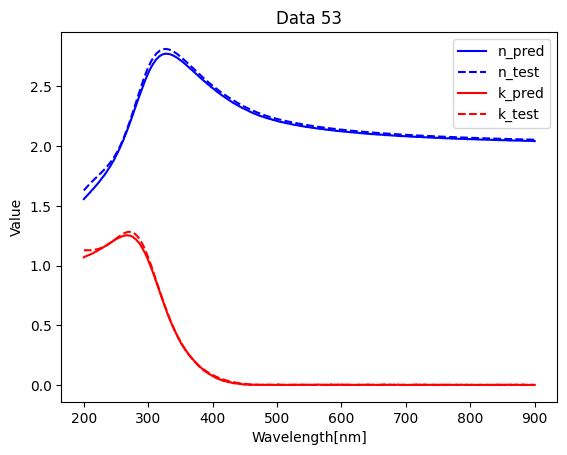

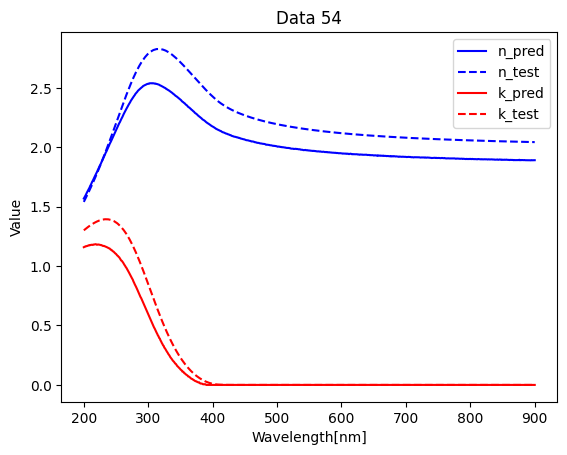

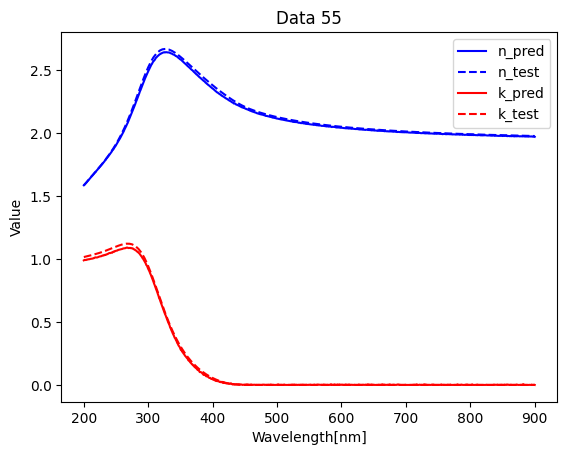

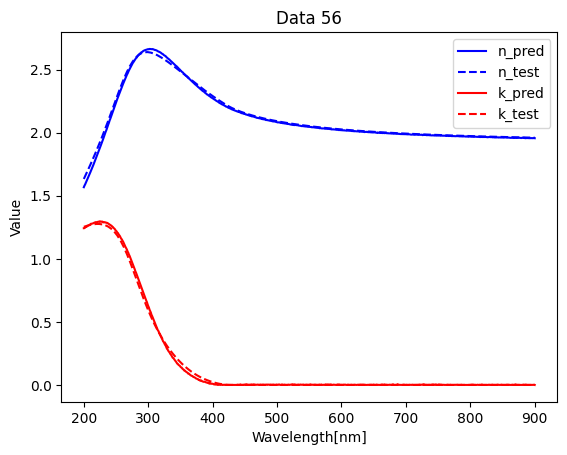

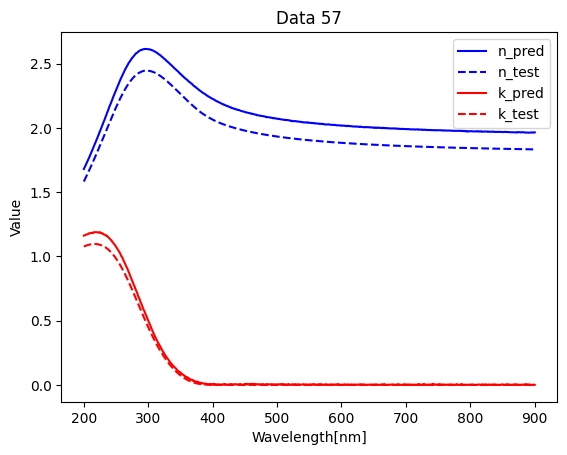

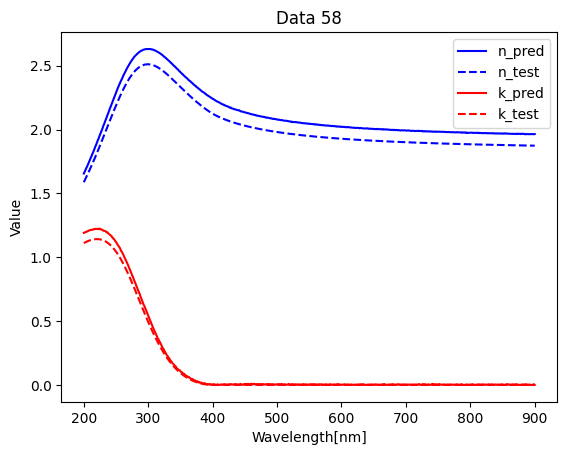

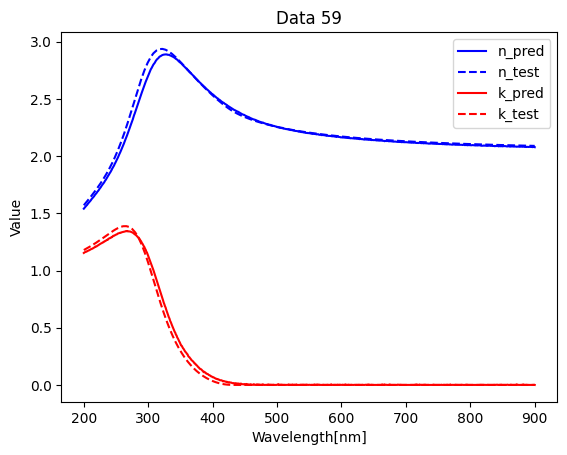

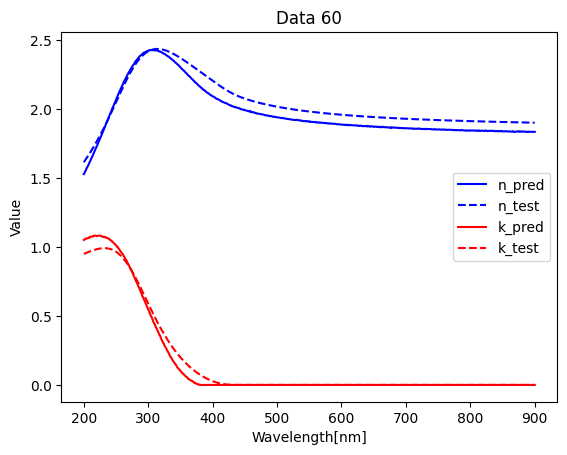

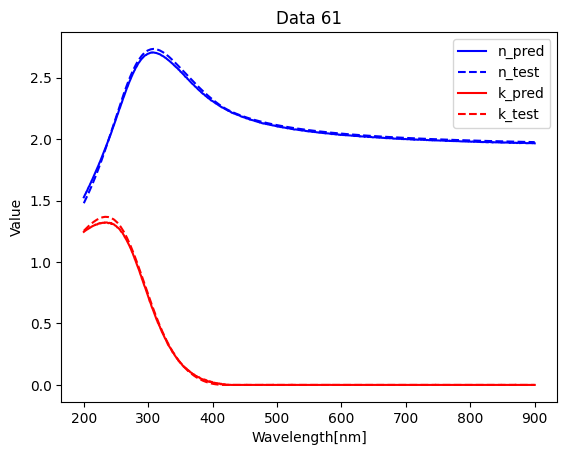

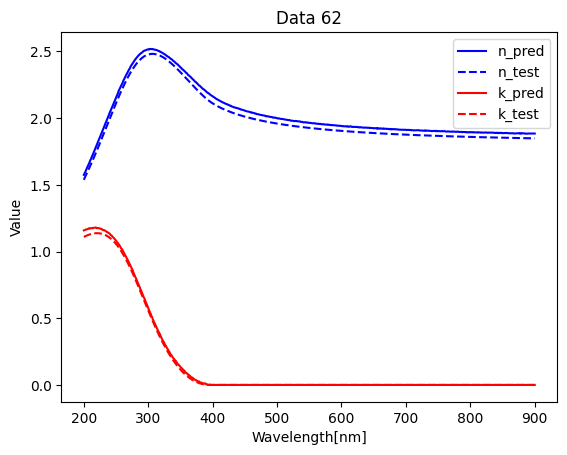

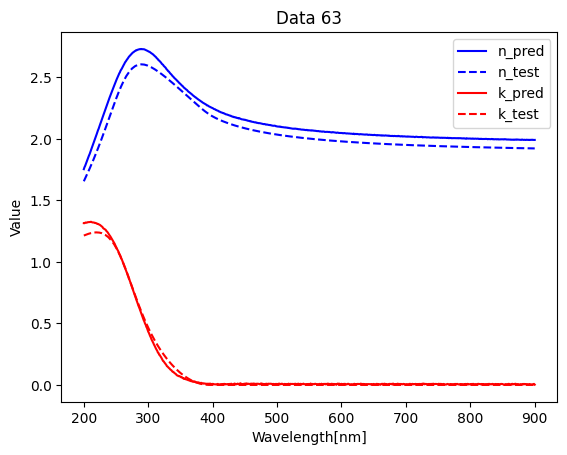

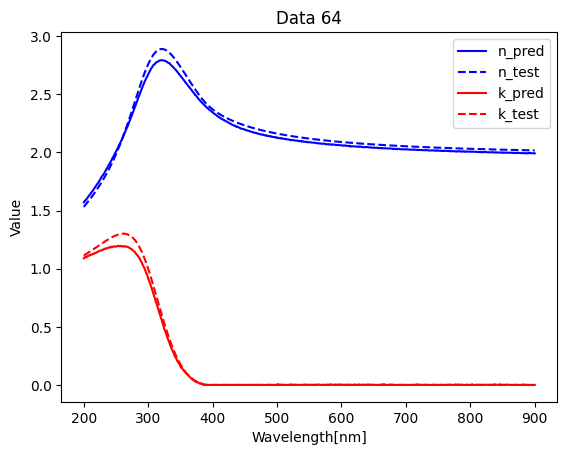

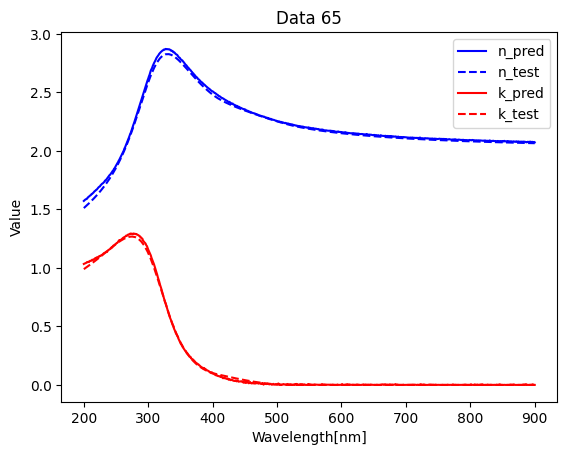

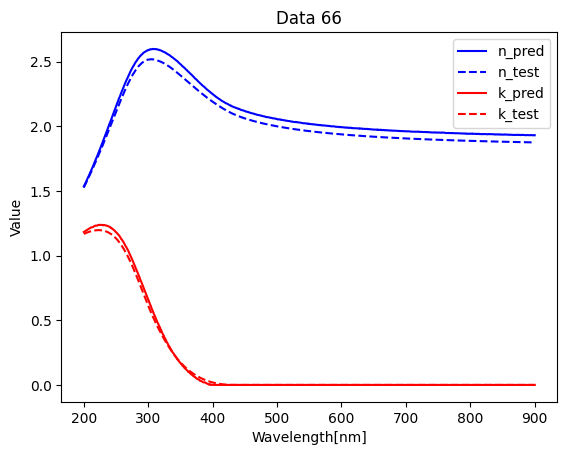

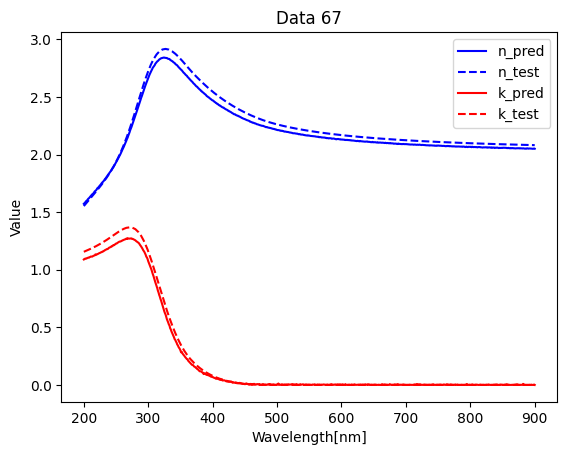

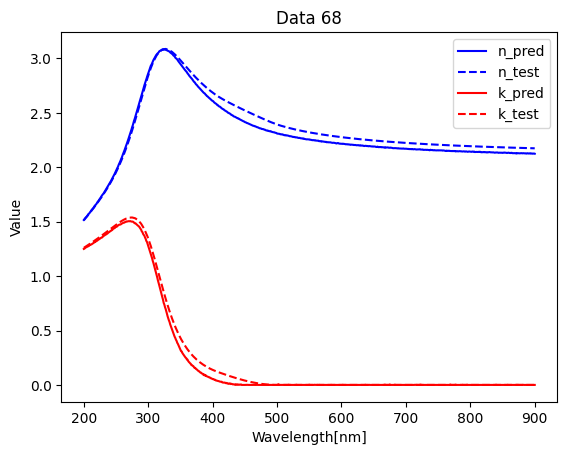

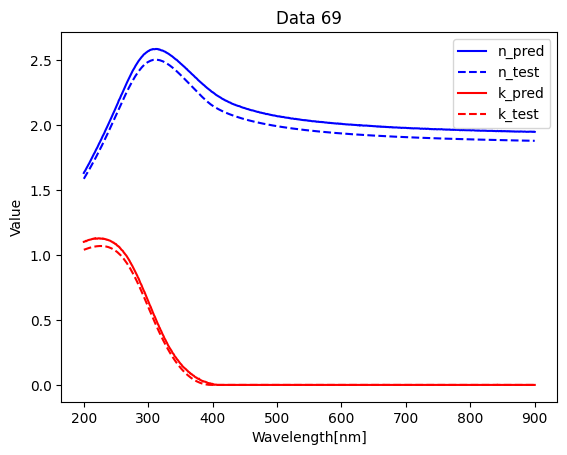

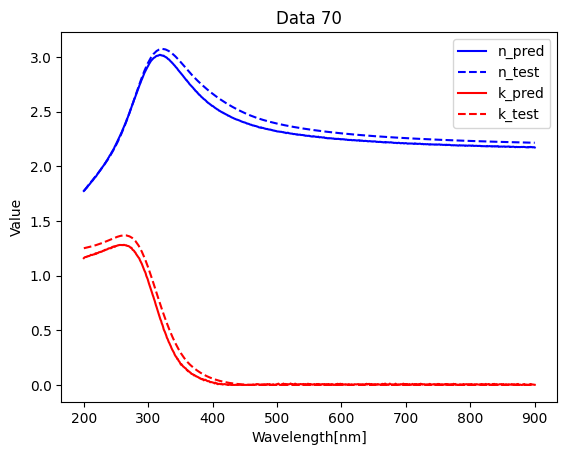

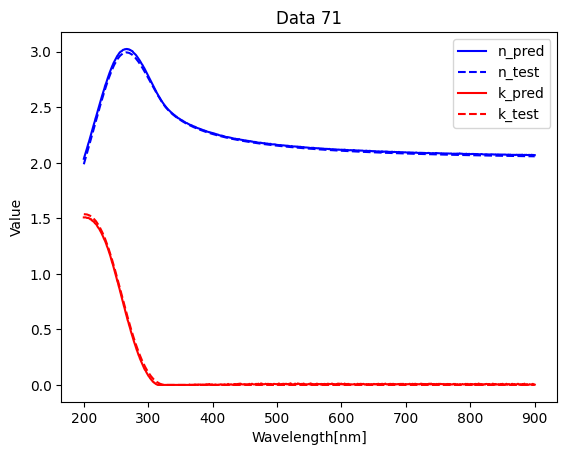

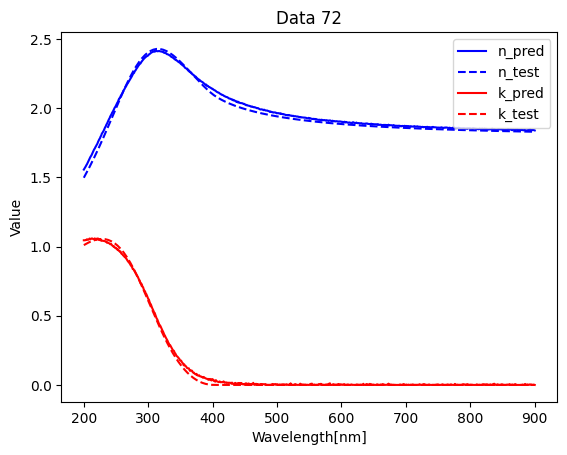

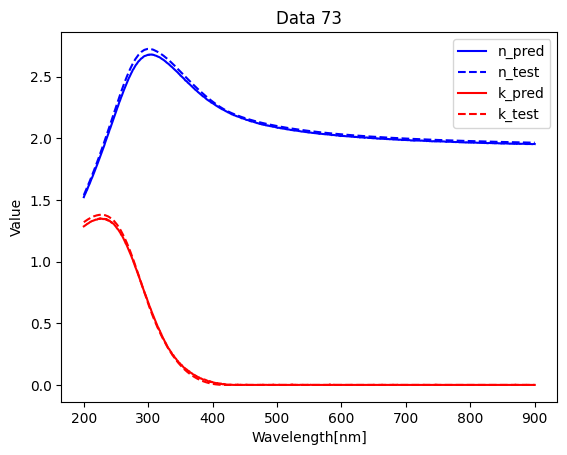

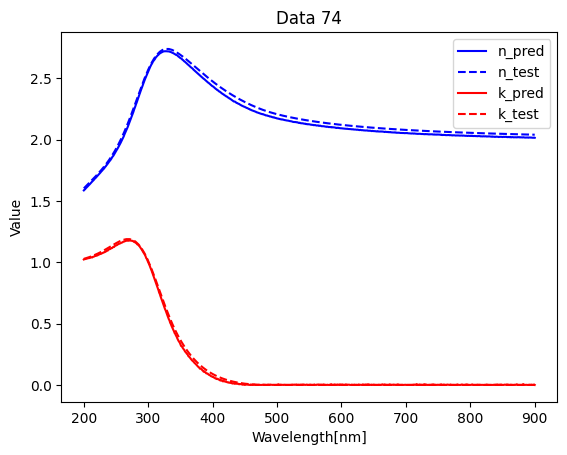

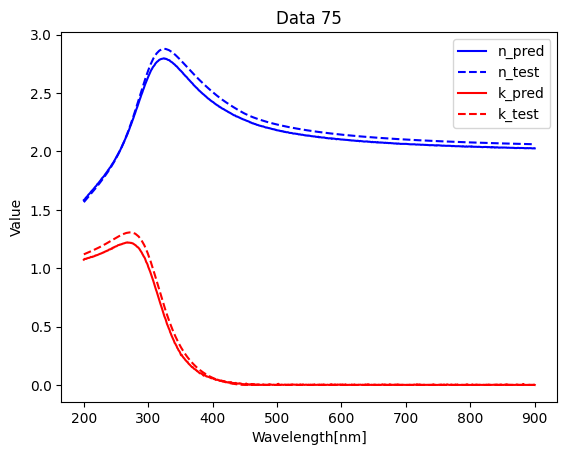

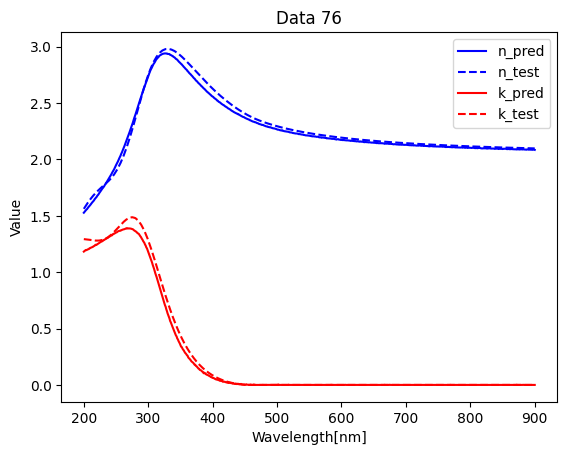

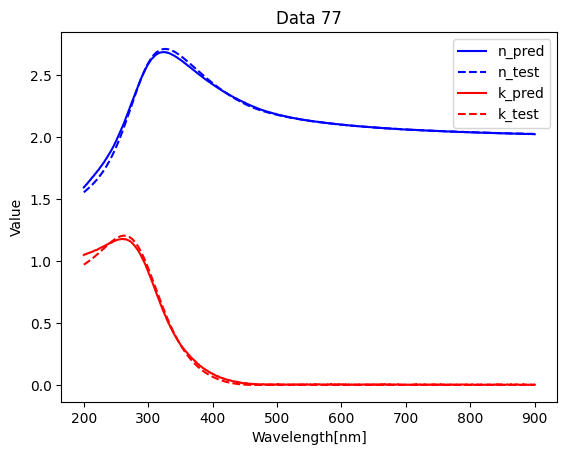

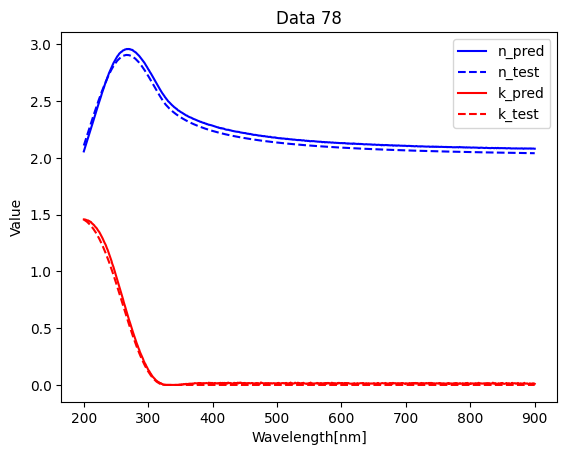

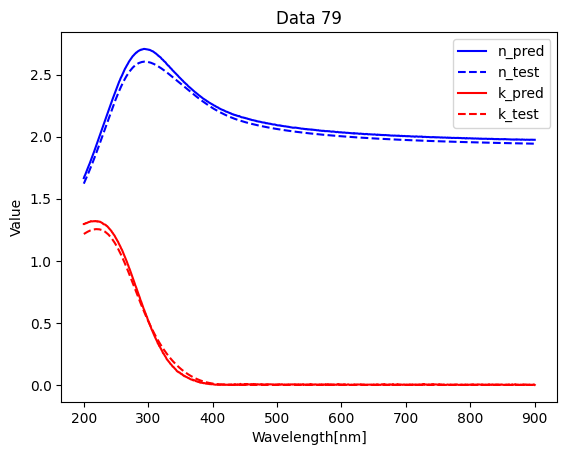

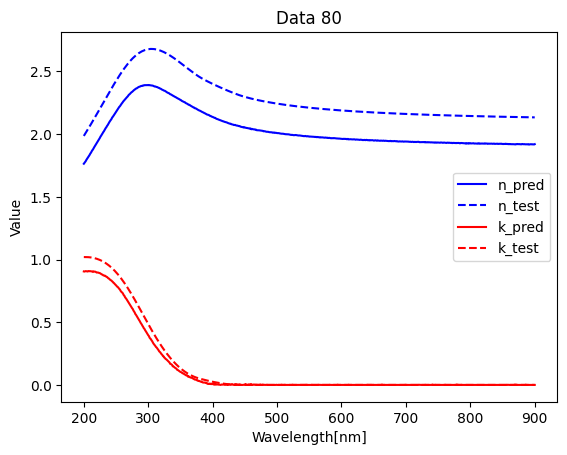

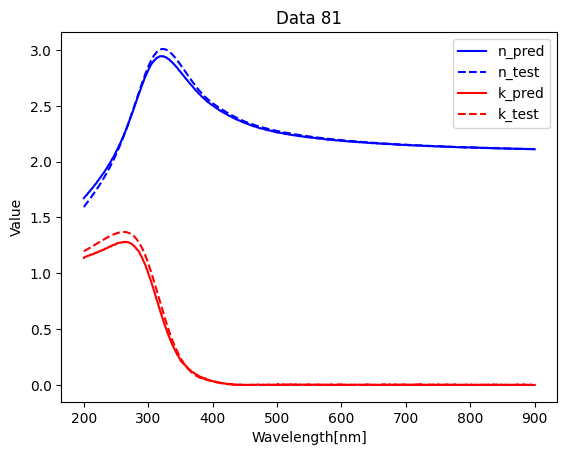

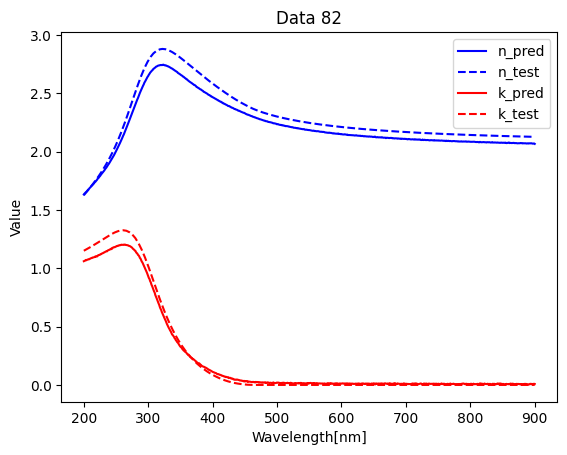

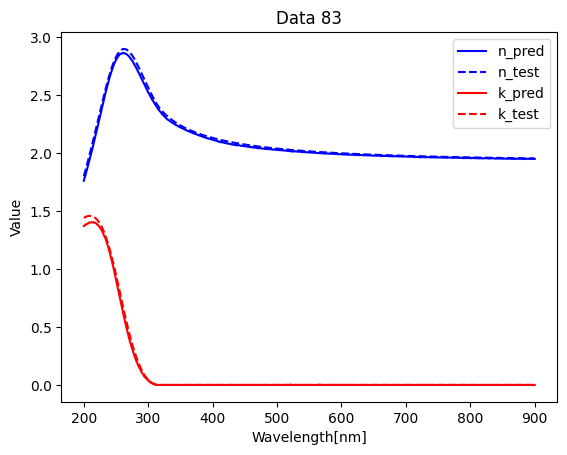

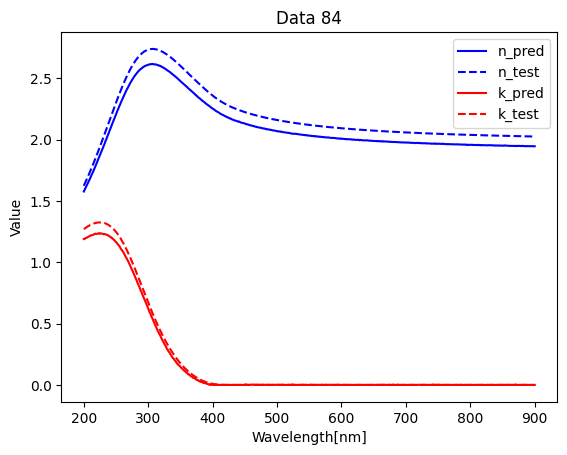

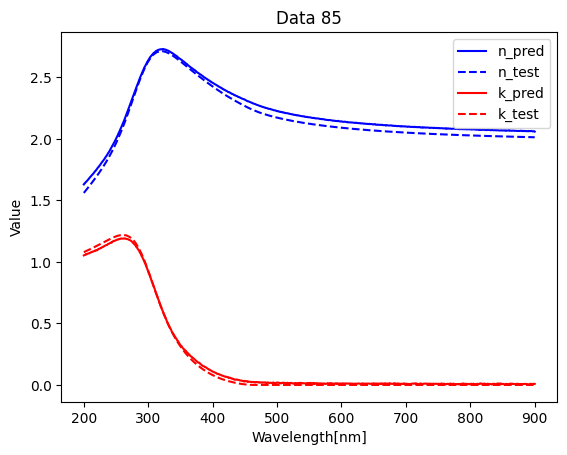

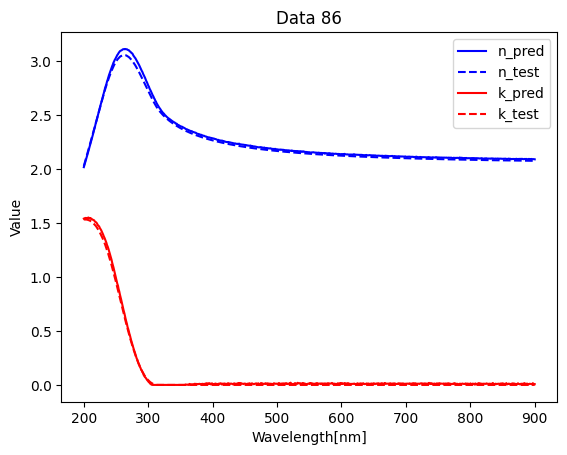

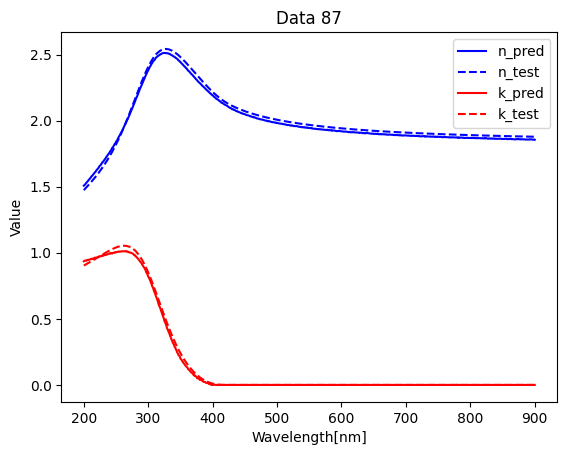

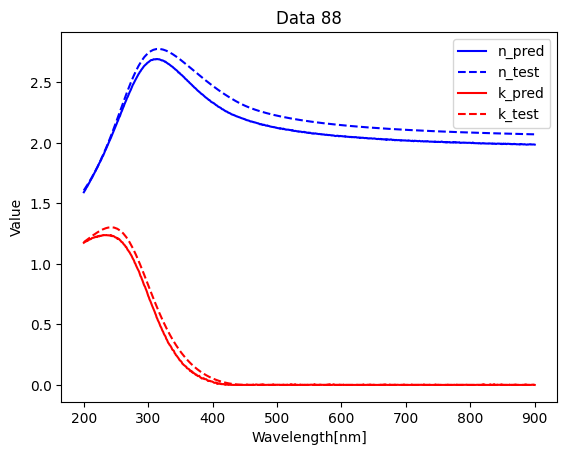

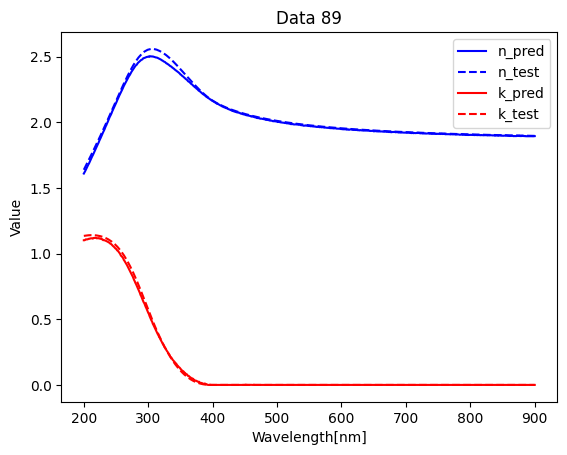

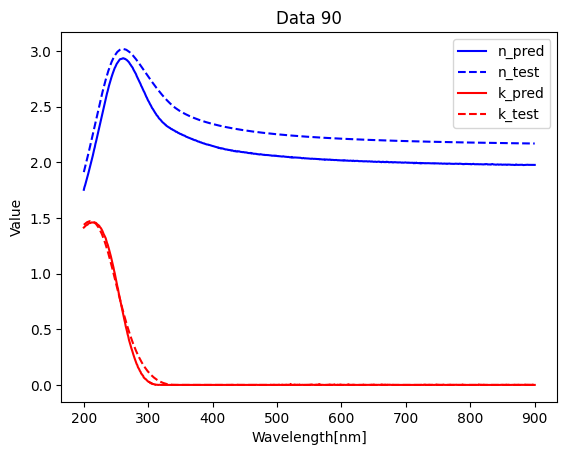

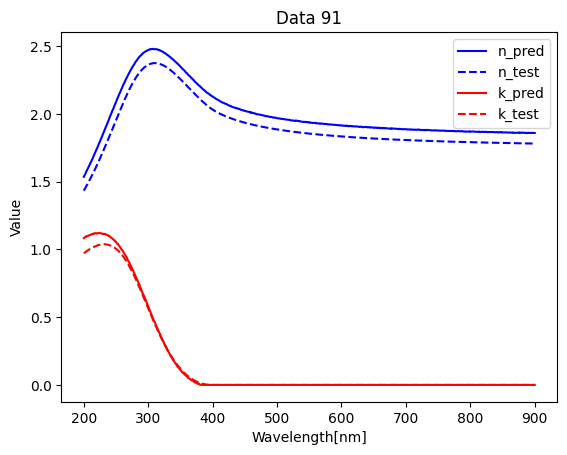

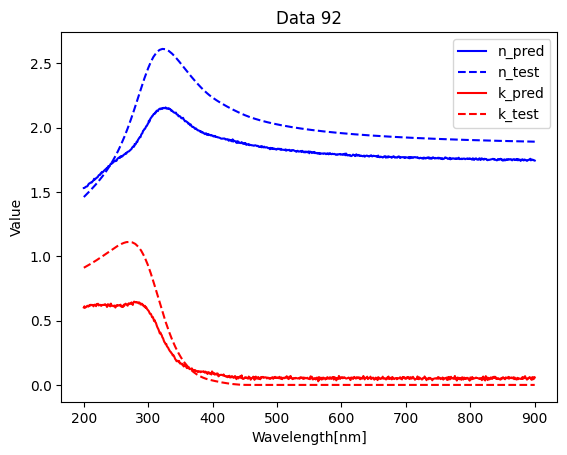

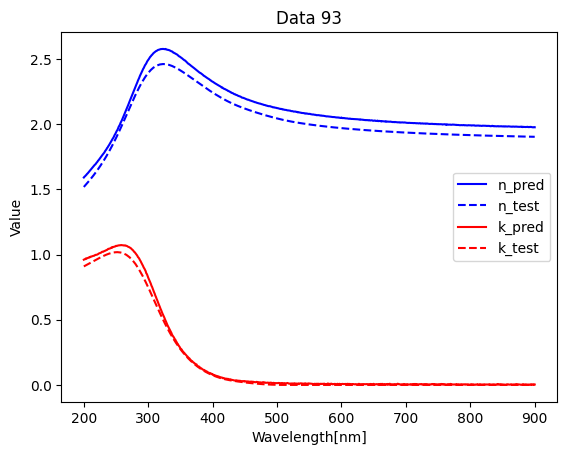

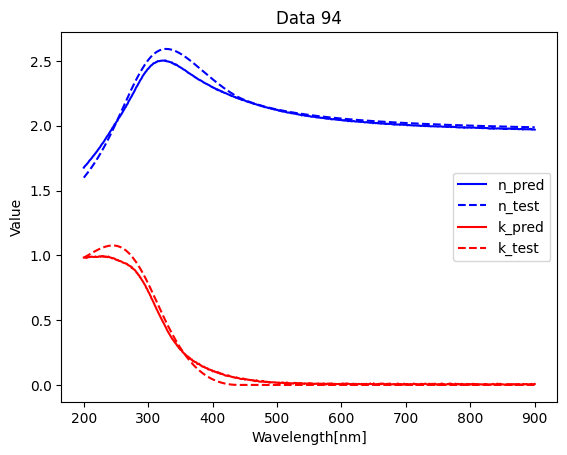

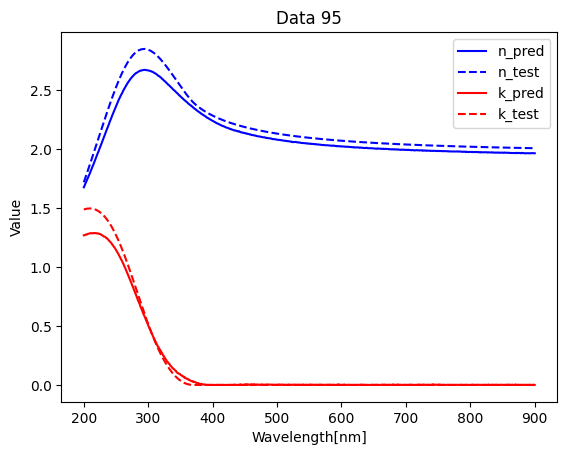

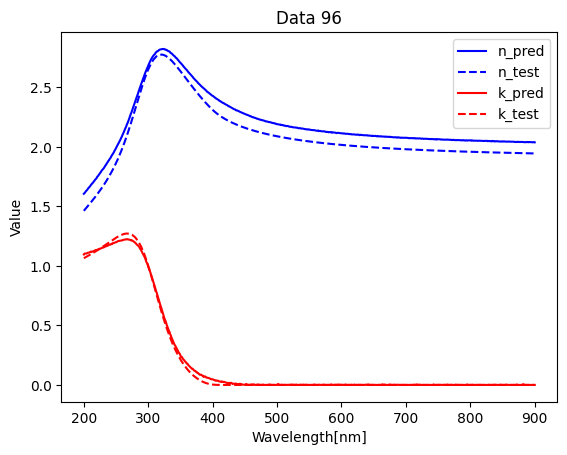

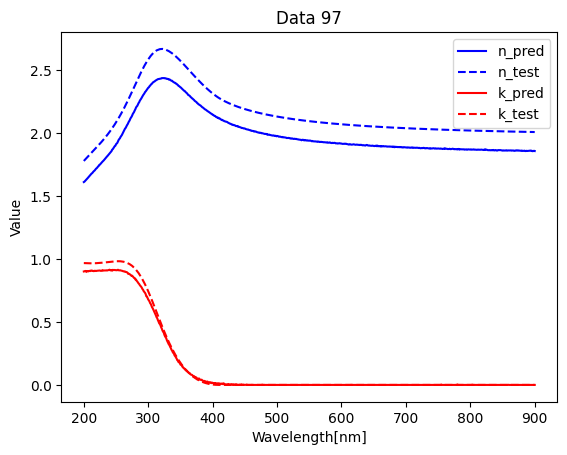

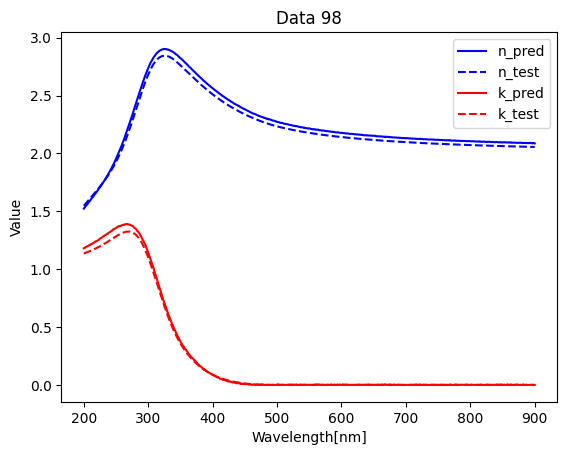

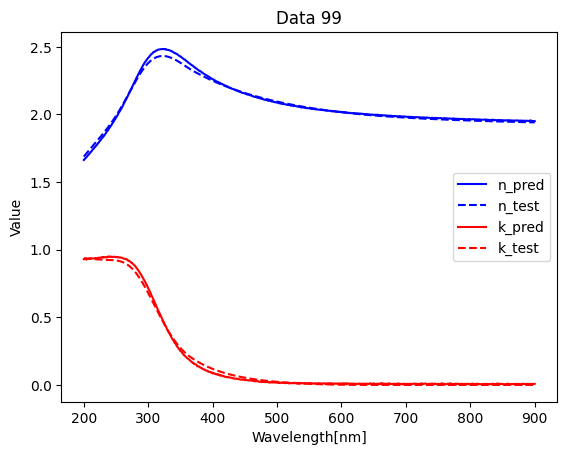

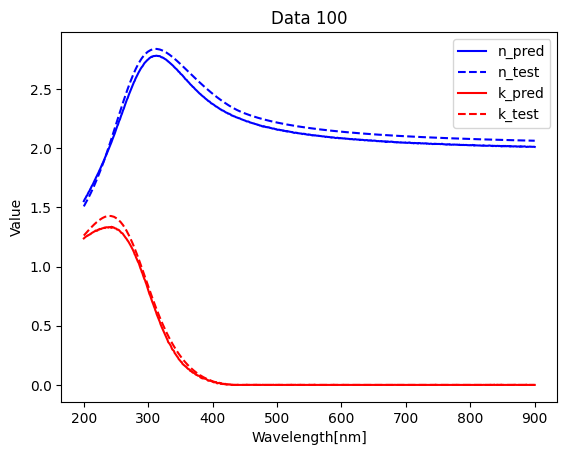

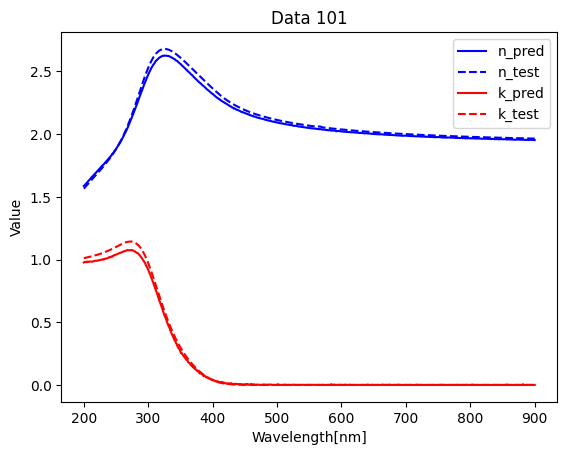

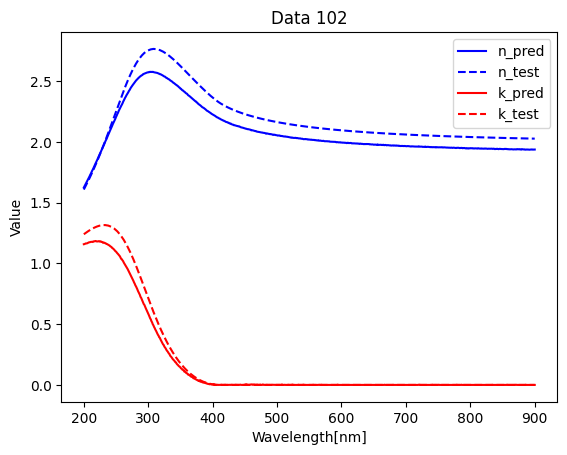

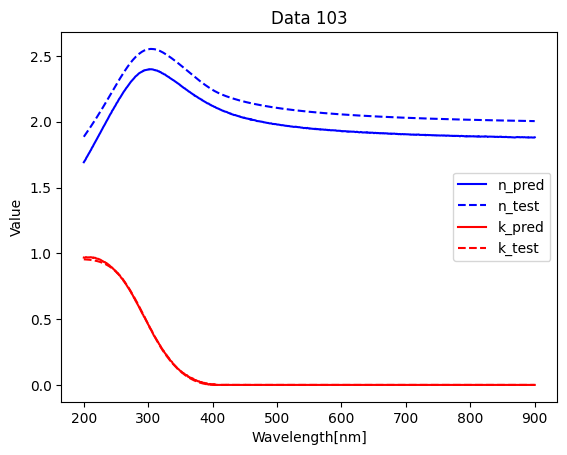

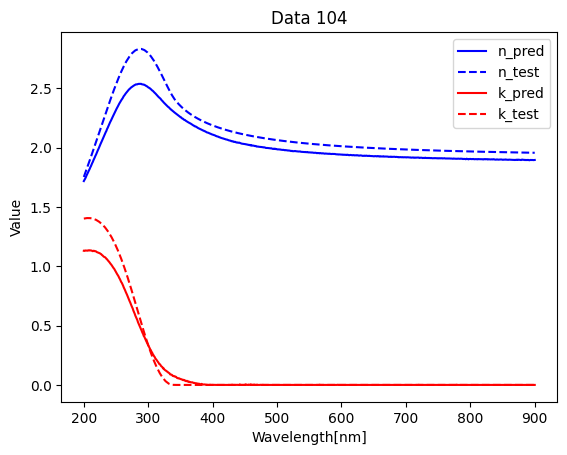

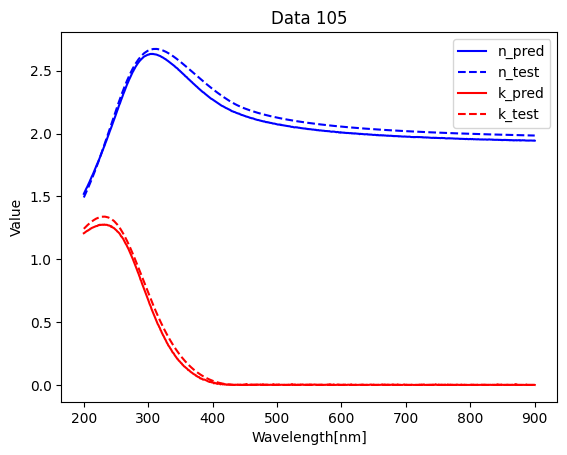

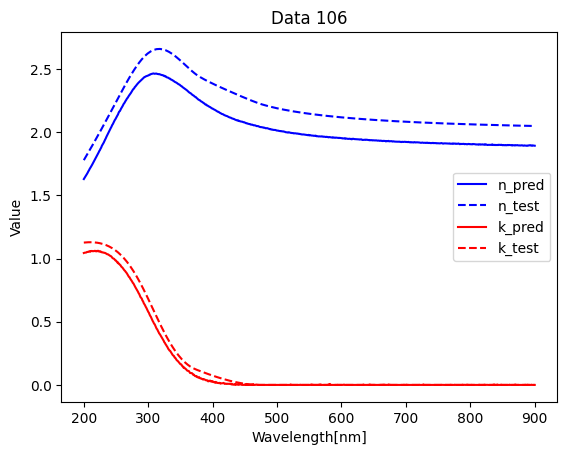

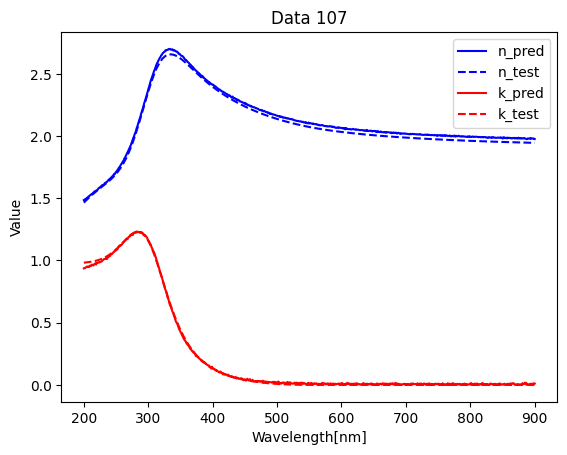

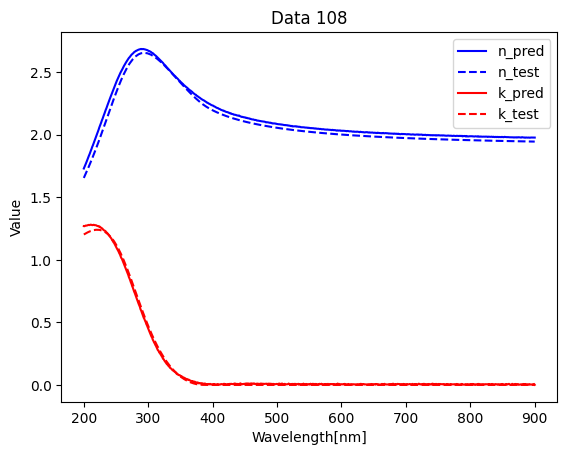

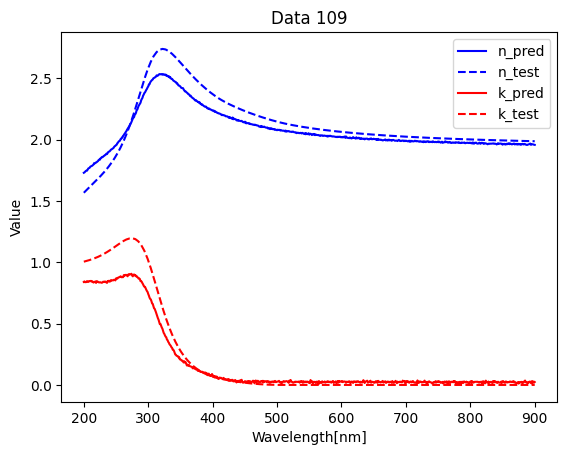

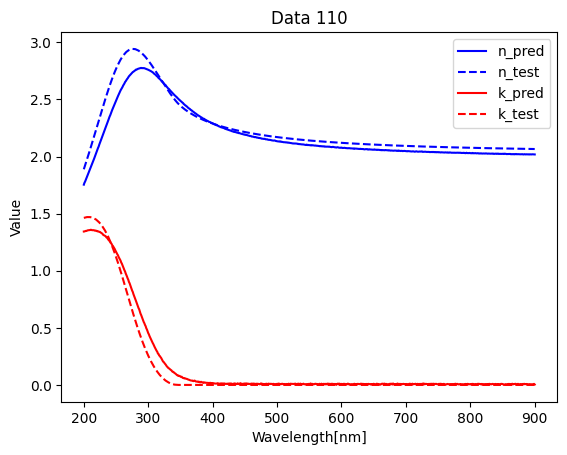

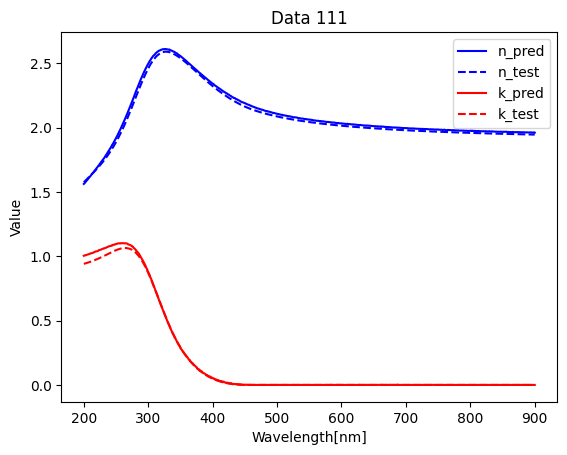

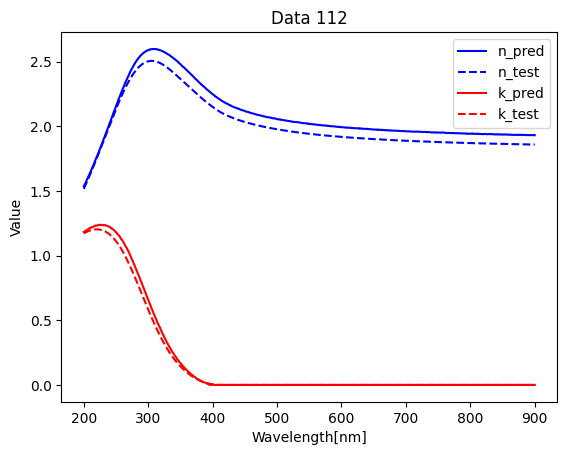

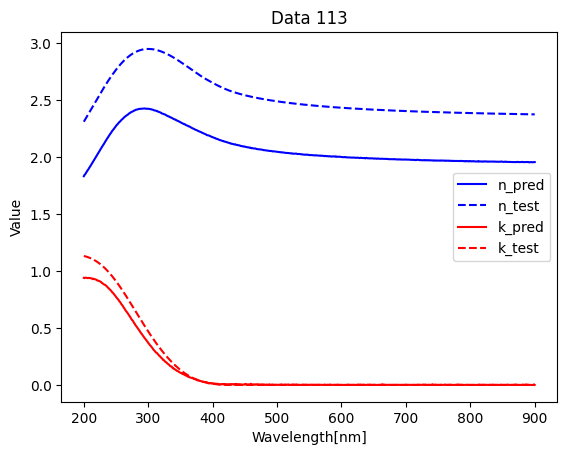

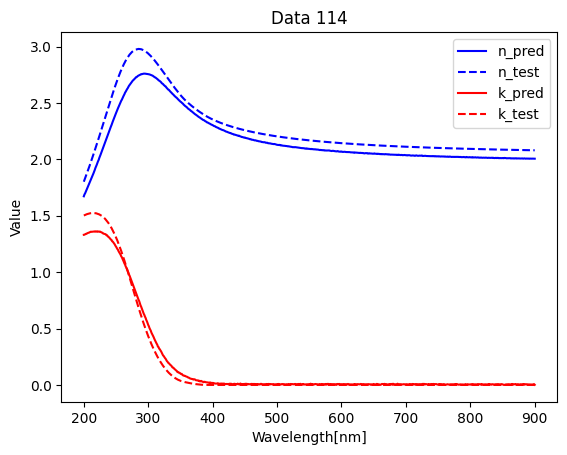

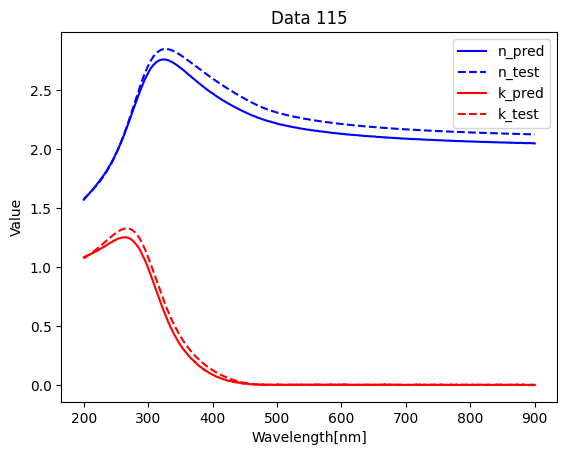

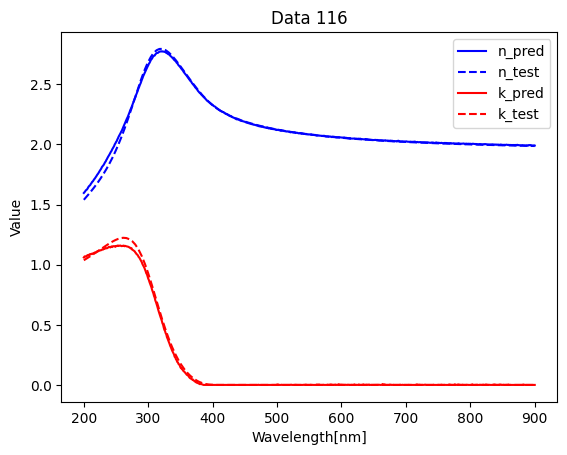

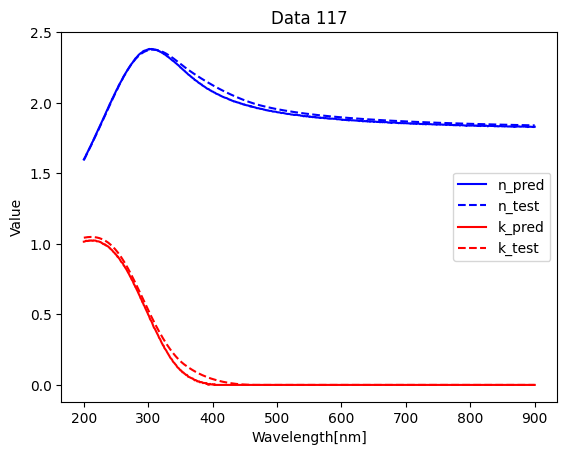

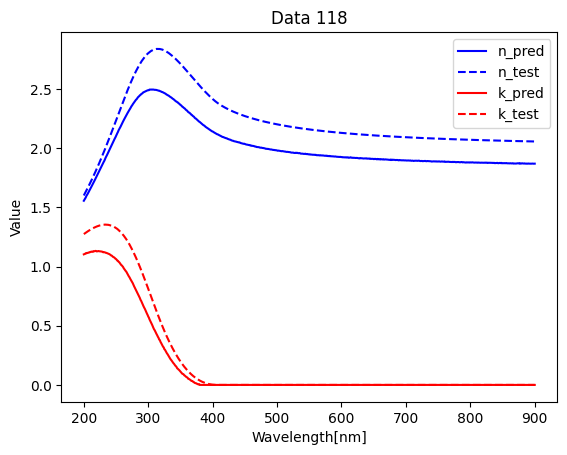

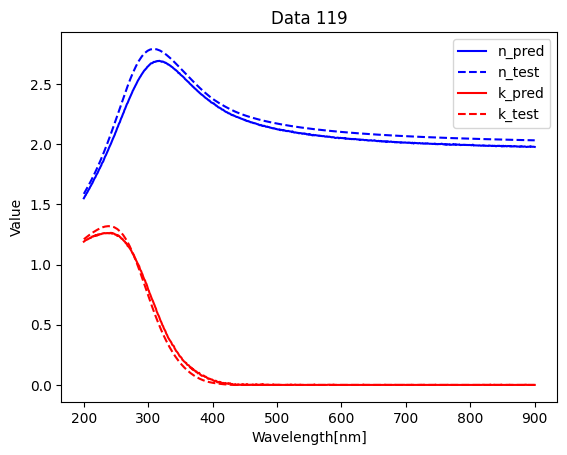

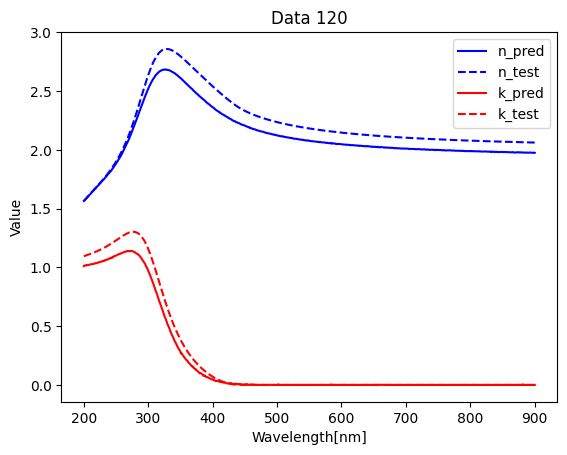

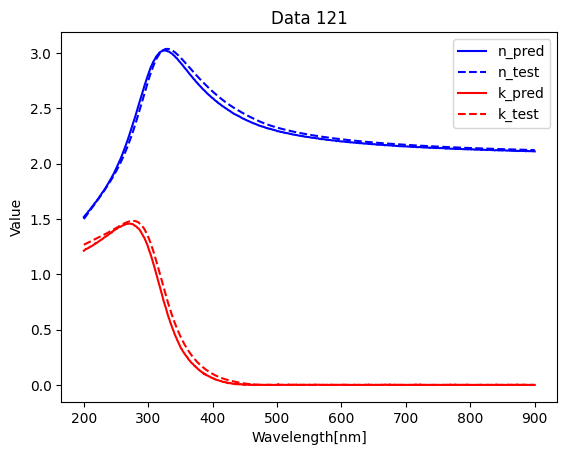

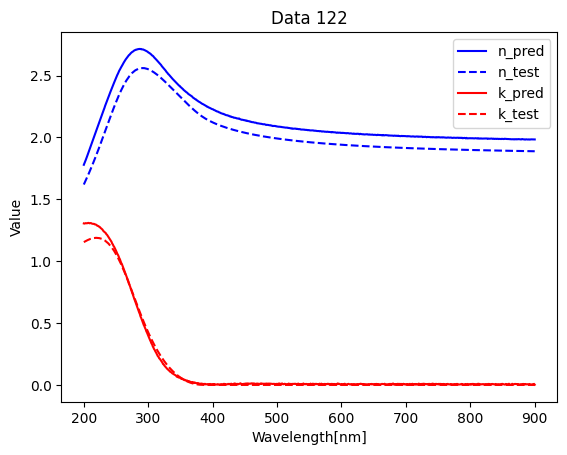

In [30]:
# Generate X-axis data
wavelength = range(200, 901)

# Go through 122 data and draw four curves
for i in range(122):
    plt.figure()
    plt.plot(wavelength, n_pred[i], 'b-', label='n_pred')
    plt.plot(wavelength, n_test[i], 'b--', label='n_test')
    plt.plot(wavelength, k_pred[i], 'r-', label='k_pred')
    plt.plot(wavelength, k_test[i], 'r--', label='k_test')
    
    plt.xlabel('Wavelength[nm]')
    plt.ylabel('Value')
    plt.title('Data {}'.format(i+1))
    plt.legend()
    plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5804\2787960095.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3.0)  # Add vertical spacing


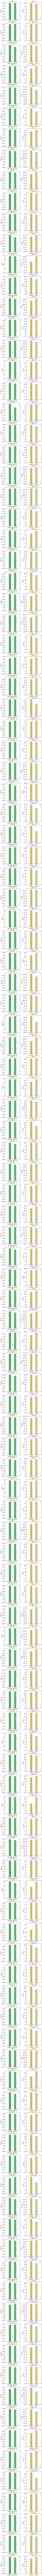

In [89]:
# Create figure and subplot for Eg_pred and Eg_test
fig, axs = plt.subplots(122, 2, figsize=(7, 500), gridspec_kw={'wspace': 0.4})  # Add horizontal spacing between subplots

# Plot Eg_pred and Eg_test
for i in range(len(Eg_pred)):
    axs[i, 0].bar([0.33, 0.67], [Eg_pred[i], Eg_test[i]], color=['g', 'g'], width=0.15, hatch=['','//'])  # Adjust width of the bars, change color for Eg_test
    axs[i, 0].set_xlim(0, 1) 
    axs[i, 0].set_xticks([0.33, 0.67])
    axs[i, 0].set_xticklabels(['Eg_pred', 'Eg_test'])
    axs[i, 0].set_ylabel('Eg[eV]')
    axs[i, 0].set_title('Data {}'.format(i+1))

    axs[i, 1].bar([0.33, 0.67], [d_pred[i], d_test[i]], color=['y', 'y'], width=0.15, hatch=['','//'])  # Adjust width of the bars, change color for d_test
    axs[i, 1].set_xlim(0, 1) 
    axs[i, 1].set_xticks([0.33, 0.67])
    axs[i, 1].set_xticklabels(['d_pred', 'd_test'])
    axs[i, 1].set_ylabel('d[nm]')
    axs[i, 1].set_title('Data {}'.format(i+1))

# Adjust layout
plt.tight_layout(pad=3.0)  # Add vertical spacing

# Show the plot
plt.show()